In [1]:
## Packages
'''Import all the necessary packages and modules'''

import numpy as np # package for playing with matrices
from scipy import signal as ss
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter 
import pandas as pd # useful for keeping cell structure and 2d data manipulation
import glob # helps find path 

In [2]:
## Functions
''' Run cell to use functions'''
def normalize(raw):
    norm=[]
    for i in raw:
        if i<0:
            norm.append(-i/min(raw))
        elif i>0:
            norm.append(i/max(raw))
        else:
            norm.append(i)
    return norm
def lowpass_filter(YA,sample_range,filter_size): #YA data set, measured sample range, filter_size arbitrary frequency cutoff based on number of samples
                   
    r=YA.shape[0]                   
    s=sample_range #GHz
    z=np.fft.fftfreq(r)/(2*s)*r
    B=filter_size
    e=int((B)/z[1])
    t=np.linspace(0, s, r)

    fYA=np.fft.rfft(YA)
    filter_e=e
    fYAr=np.zeros(fYA.shape[0])
    fYAl=np.zeros(fYA.shape[0])
    fYAr[:filter_e]=np.real(fYA[:filter_e])
    fYAl[:filter_e]=np.imag(fYA[:filter_e])
    fYA_filt=np.array(fYAr)+np.array(1j*fYAl)
    ifY=np.fft.irfft(fYA_filt)
    return ifY

def list_around(X,rang): # X is a number rang is the range around e.g X=8 rang=2 => list [6,7,8,9,10]
    lis=list(range(int(X)-int(rang),int(X)+int(rang)))
    
    return lis

In [9]:
## Data Directory GUI - Choose DC data
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''

root = Tk() # Tk() is a function in tkinter that opens a window
root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
#root.file = fieldialog.askopenfilename()
root.withdraw() # closes the tkinter window since it's unnecessary
oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root.directory) # sets new directory
newcwd = os.getcwd() # saves new directory name as newcwd
path = root.directory + '/*.csv' # creates path to data set folder directory. Change .csv to file type as needed
a=0 # counter for looping through list starting at 0
file_list=glob.glob(path)
file_list

['E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Cable1.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Cable2.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port1A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port1B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port2A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port2B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port3A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port3B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to c

In [10]:
## Load Data  use for .csv data
''' Open data and set up for analysis'''

num_files = np.size(file_list) # number of files in the directory with the correct file type
file_shape = np.array(pd.read_csv(glob.glob(path)[0]).values.shape) # data file size
Header = 4 #Removes string header to work with numpy array
file_shape[0]=file_shape[0]-Header # new file shape after removal of header
matrix_shape = np.append(file_shape, num_files) # size of matrix to hold all data
data_array = np.empty(matrix_shape) # builds empty matrix of size matrix_shape
for fname in file_list: #iterates through files along order of glob.glob(path)

    data = pd.read_csv(fname) # uses pandas to open files and keep structure
    data=data.drop(data.index[0:Header]) #Removes rows of header
    datapd = data.values # converts from dataframe to numpy array
    
    data_array[:,:,a] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
    a+=1 # increase counter to progress through list
    

In [11]:
## Curate DC chip data before plotting
''' Separates data into new matrixes between A-no chip and B-with chip. Also applies filter'''

for_counter = np.arange(2,num_files-2,2)
a=0
num_cables=7
new_file_shape1=file_shape[1]-1
new_file_shape=np.append(file_shape[0]-1,new_file_shape1)
new_file_shape_orig=np.append(file_shape[0],new_file_shape1)
cable_data_matrix = np.append(new_file_shape,num_cables)
cable_data_matrix_orig = np.append(new_file_shape_orig,num_cables)
data_Ac_1=np.empty(cable_data_matrix)  #preallocates matrix size
data_Ac_1_orig=np.empty(cable_data_matrix_orig)
data_Bc_1=np.empty(cable_data_matrix)
data_Bc_1_orig=np.empty(cable_data_matrix_orig)
data_A_1=np.empty(cable_data_matrix)
data_A_1_orig=np.empty(cable_data_matrix_orig)
data_A_2=np.empty(cable_data_matrix)
data_A_2_orig=np.empty(cable_data_matrix_orig)
data_B_1=np.empty(cable_data_matrix)
data_B_1_orig=np.empty(cable_data_matrix_orig)
data_B_2=np.empty(cable_data_matrix)
data_B_2_orig=np.empty(cable_data_matrix_orig)


for counter in for_counter:
    
    data_Ac_1[:,0,a]=data_array[:-1,0,counter] # Cable x data
    data_Ac_1_orig[:,0,a]=data_array[:,0,counter] # Orig Cable x data
    
    data_Ac_1[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3) # Cable y data
    data_Ac_1_orig[:,1,a]=data_array[:,1,counter] # Orig Cable y data
    
    data_A_1[:,0,a]=data_array[:-1,0,counter] # Cable1 and holder for A series x data   
    data_A_1_orig[:,0,a]=data_array[:,0,counter] # Cable1 and holder for A series x data 
    
    data_A_2[:,0,a]=data_array[:-1,0,counter] # Cable2 and holder for A series x data
    data_A_2_orig[:,0,a]=data_array[:,0,counter] # Cable2 and holder for A series x data  
    
    data_A_1[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3)-lowpass_filter(data_array[:,1,0],9,3) # Holder-Cable1 for A series y data 
    data_A_1_orig[:,1,a]=data_array[:,1,counter]-data_array[:,1,0] # Orig Holder-Cable1 for A series y data 
    
    data_A_2[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3)-lowpass_filter(data_array[:,1,1],9,3) # Holder-Cable2 for A series y data 
    data_A_2_orig[:,1,a]=data_array[:,1,counter]-data_array[:,1,1] # Orig Holder-Cable1 for A series y data 
    
    data_B_1[:,0,a]=data_array[:-1,0,counter+1] # Cable1 and holder for A series x data  
    data_B_1_orig[:,0,a]=data_array[:,0,counter+1] # Orig Cable1 and holder for A series x data 
    
    data_B_2[:,0,a]=data_array[:-1,0,counter+1] # Cable2 and holder for A series x data
    data_B_2_orig[:,0,a]=data_array[:,0,counter+1] # Cable2 and holder for A series x data
    
    data_B_1[:,1,a]=lowpass_filter(data_array[:,1,counter+1],9,3)-lowpass_filter(data_array[:,1,0],9,3) # Holder-Cable1 for A series y data 
    data_B_1_orig[:,1,a]=data_array[:,1,counter+1]-data_array[:,1,0] # Orig Holder-Cable1 for A series y data 
    
    data_B_2[:,1,a]=lowpass_filter(data_array[:,1,counter+1],9,3)-lowpass_filter(data_array[:,1,1],9,3) # Holder-Cable2 for A series y data 
    data_B_2_orig[:,1,a]=data_array[:,1,counter+1]-data_array[:,1,1] # Orig Holder-Cable2 for A series y data 
    
    a+=1

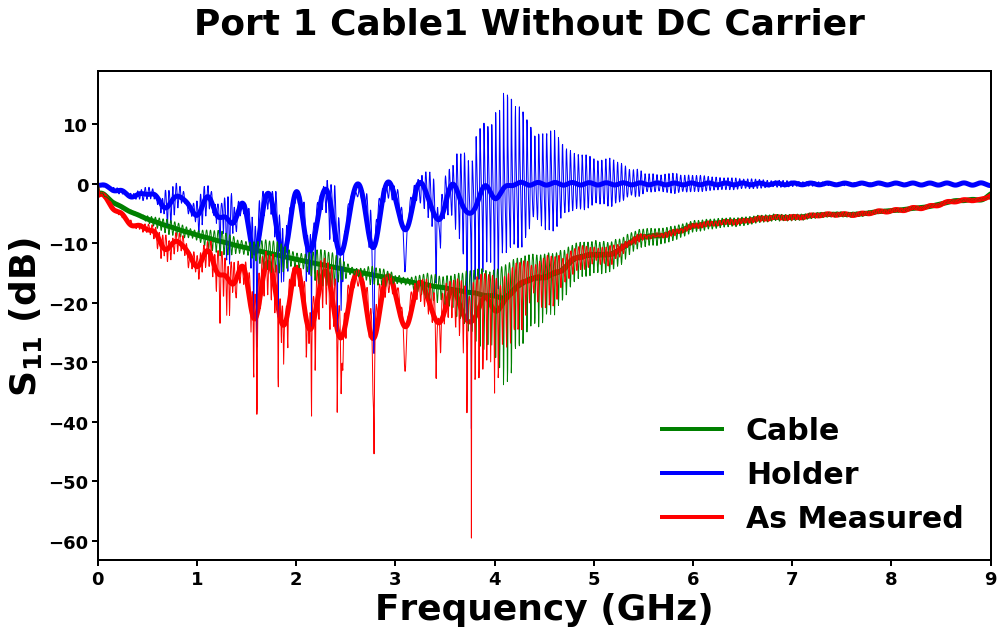

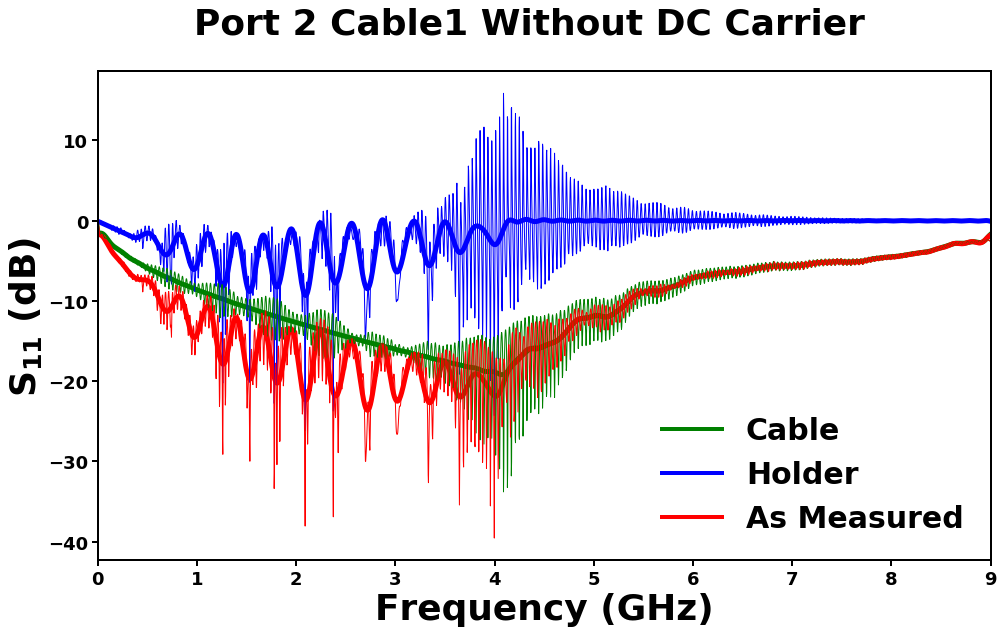

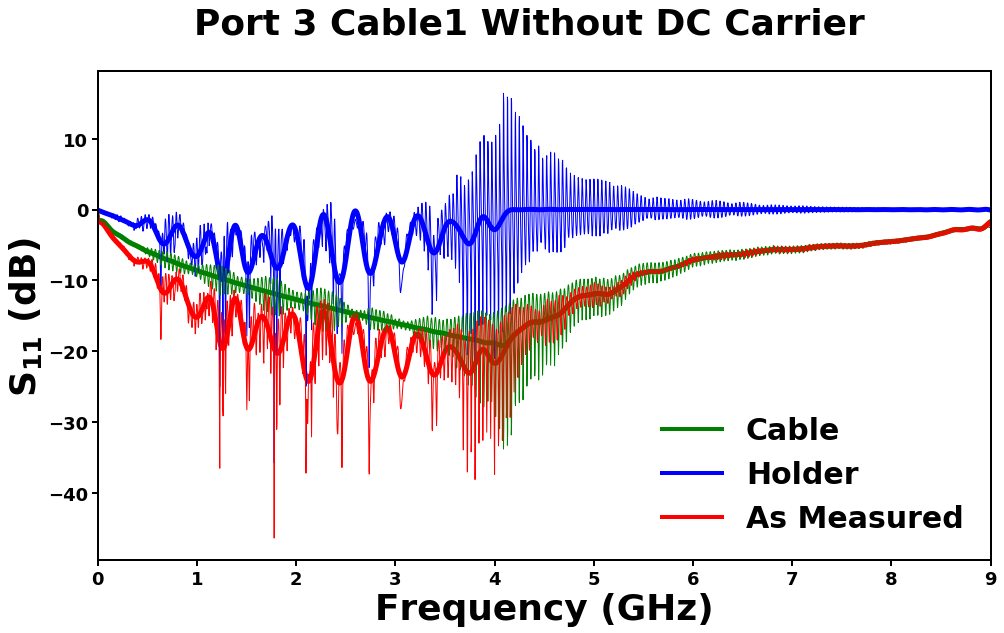

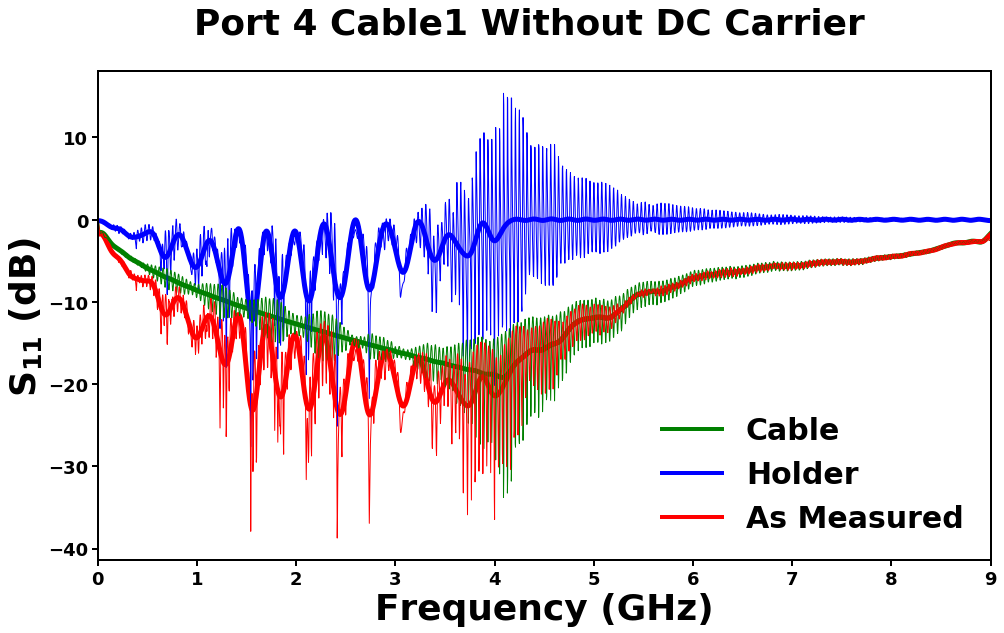

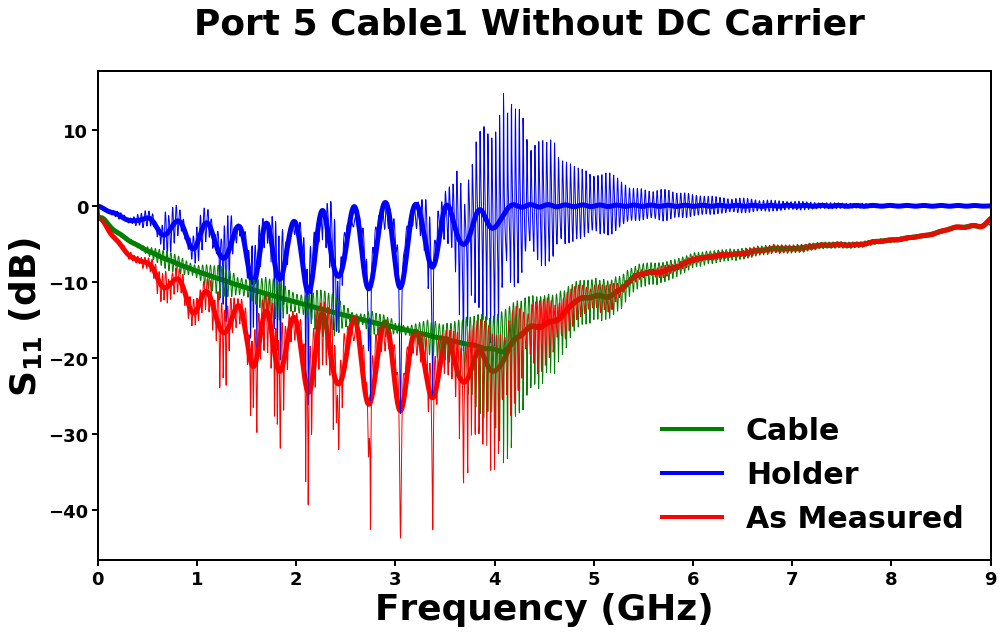

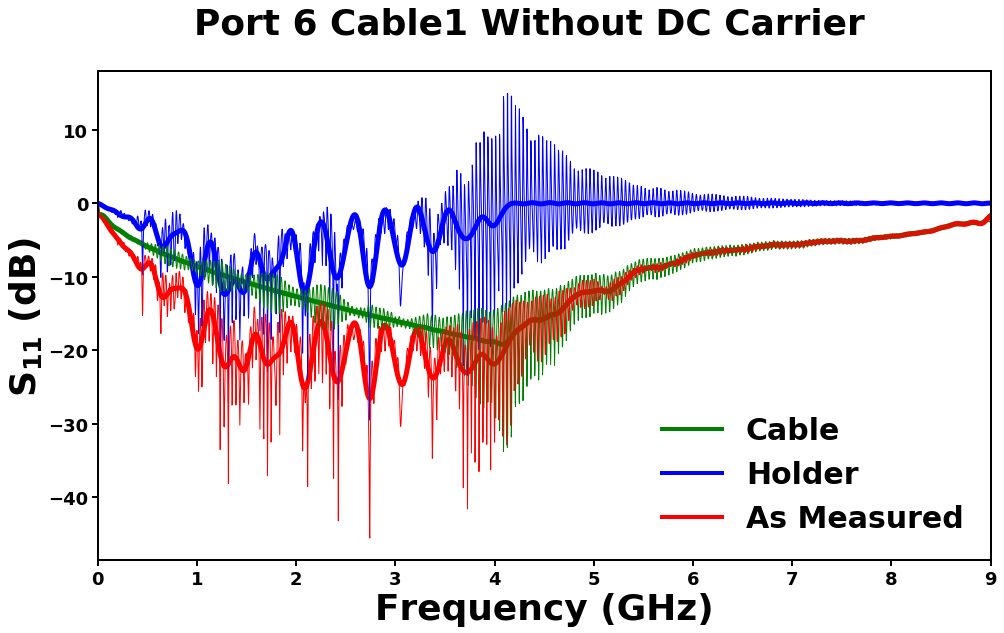

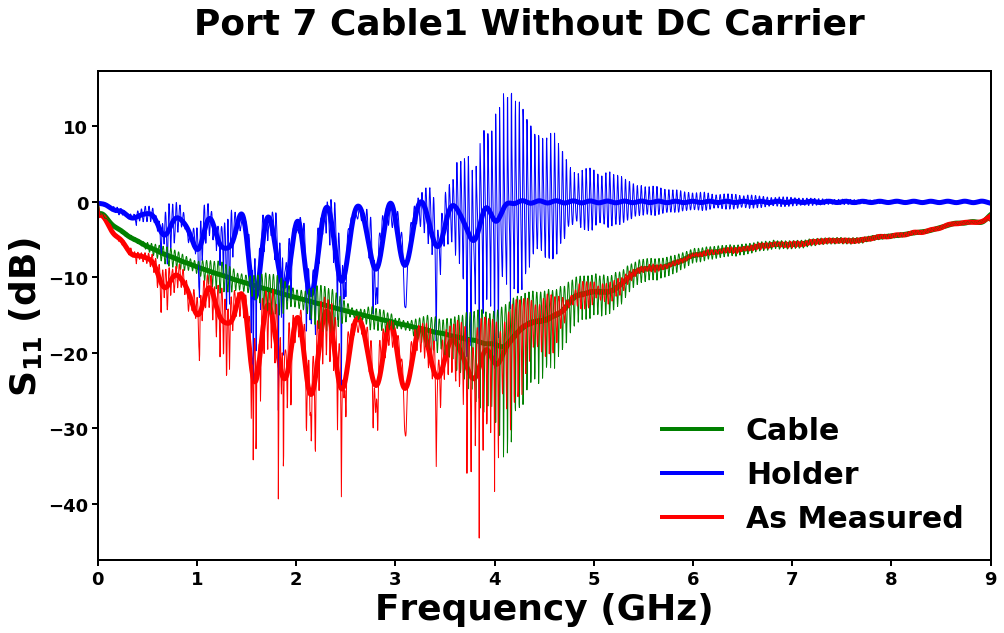

In [12]:
## Plots DC chip data
''' Change indexes or A->B if you want to plot data from no chip-> with chip. Also change from cable 1 to 2 and the naming.
Only took data of all the samples with Cable 1. Just took background of Cable 2'''
plot_file=np.arange(0,7)

data_array_order=[2,4,6,8,10,12,14] #Used for plotting A experiments
data_array_order1=[3,5,7,9,11,13,15] #Used for plotting B experiments

data_dc=np.zeros(cable_data_matrix_orig)
data_dc_filt=np.zeros(cable_data_matrix)

Ax_orig=np.zeros(data_A_1_orig.shape[0::2])
Ax_filt=np.zeros(data_A_1.shape[0::2])

Ay_orig=np.zeros(data_A_1_orig.shape[0::2])
Ay_filt=np.zeros(data_A_1.shape[0::2])

Bx_orig=np.zeros(data_B_1_orig.shape[0::2])
Bx_filt=np.zeros(data_B_1.shape[0::2])

By_orig=np.zeros(data_B_1_orig.shape[0::2])
By_filt=np.zeros(data_B_1.shape[0::2])


for n in plot_file:
    
    X=data_A_1[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X_orig=data_A_1_orig[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X1=data_B_1[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X1_orig=data_B_1_orig[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    Ax_orig[:,n]=X_orig;
    Ax_filt[:,n]=X;
    
    Bx_orig[:,n]=X1_orig;
    Bx_filt[:,n]=X1;
    
    YA=data_A_1[:,1,plot_file[n]]; 
    YA_orig=data_A_1_orig[:,1,plot_file[n]]; 
    
    Ay_orig[:,n]=YA_orig; #Capture all the holder and chip data
    Ay_filt[:,n]=YA; #Capture all the holder and chip data filtered
    
    YB=data_B_1[:,1,plot_file[n]];
    YB_orig=data_B_1_orig[:,1,plot_file[n]];
    
    By_orig[:,n]=YB_orig; # Capture all the just holder data
    By_filt[:,n]=YB; # Capture all just holder and filtered
    
    y1c=data_Ac_1[:,1,plot_file[n]];
    y1c_orig=data_Ac_1_orig[:,1,plot_file[n]];
    
    y1=lowpass_filter(data_array[:,1,0],9,3); #0 for cable 1 and 1 for cable 2 in the z position
    y1_orig=data_array[:,1,0]; #0 for cable 1 and 1 for cable 2 in the z position
    
#     Y=YA-YB 
#     Y_orig=YA_orig-YB_orig
    
    data_dc[:,0,n]=X_orig
    data_dc_filt[:,0,n]=X
    
    data_dc[:,1,n]=YB_orig
    data_dc_filt[:,1,n]=YB
    
    name_fix=plot_file[n]+1
    plot_file_name=str(n+1)
    Data_Name = 'Port ' + plot_file_name + ' Cable1 Without DC Carrier'
    #os.path.basename(file_list[data_array_order1[n]]).split('.')[0] + ' DC WithoutChip - Cable 2' #Change name whether R=1,2 and With to Without if A or B

    plt.rc('font', weight='bold')
    plt.rcParams['axes.linewidth']=2
    plt.rcParams['figure.figsize'] = (16,9)

    fig = plt.figure()
    fig.suptitle(Data_Name, fontsize=36, fontweight='bold')

    ax = fig.add_subplot(111)

    ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
    ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')
    ax.set_xlim(0,9)
    
    ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

    fig=plt.plot(X,y1,'g-',linewidth=5, label='Cable')    
    fig=plt.plot(X,YA,'b-',linewidth=5, label='Holder')
    fig=plt.plot(X,y1c,'r-',linewidth=5, label='As Measured')
    
    fig=plt.plot(X_orig,YA_orig,'b-',linewidth=1)
    fig=plt.plot(X_orig,y1_orig,'g-',linewidth=1)
    fig=plt.plot(X_orig,y1c_orig,'r-',linewidth=1)    
    
    
    leg=plt.legend(fontsize=30, loc=4, frameon=False)

    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)

    plt.show()
    #save_loc='C:\\Users\\kbs1\\Documents\\TEMCarrierApr2018\\TEMCarrierApr2018' + '/' +Data_Name+'.png' #root.directory+'/'+'Updated612518'+ '/' +Data_Name+'.png'
    #plt.savefig(save_loc)

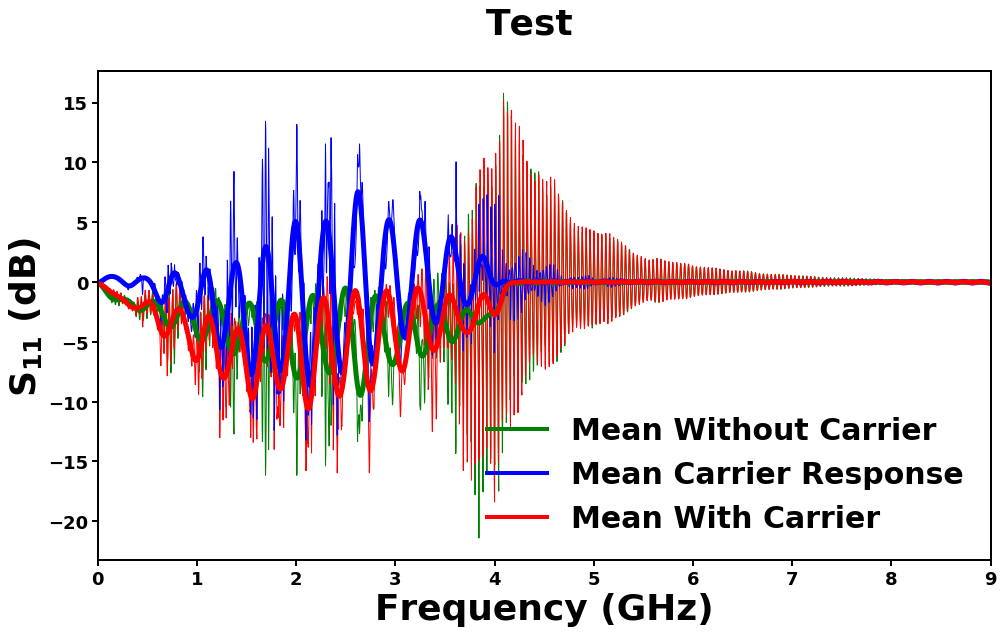

In [13]:
## Average Response
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=2
plt.rcParams['figure.figsize'] = (16,9)

fig = plt.figure()
fig.suptitle('Test', fontsize=36, fontweight='bold')

ax = fig.add_subplot(111)

ax.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
ax.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')
ax.set_xlim(0,9)
    
ax.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

Ax_orig_mean=np.mean(Ax_orig,axis=1)
Ay_orig_mean=np.mean(Ay_orig,axis=1)

Ax_filt_mean=np.mean(Ax_filt,axis=1)
Ay_filt_mean=np.mean(Ay_filt,axis=1)

Bx_orig_mean=np.mean(Bx_orig,axis=1)
By_orig_mean=np.mean(By_orig,axis=1)

Bx_filt_mean=np.mean(Bx_filt,axis=1)
By_filt_mean=np.mean(By_filt,axis=1)

Diff_orig_mean=Ay_orig_mean-By_orig_mean
Diff_filt_mean=Ay_filt_mean-By_filt_mean

# Ay_orig_mean_filt=lowpass_filter(Ay_orig_mean,5,3)

fig=plt.plot(Bx_orig_mean,By_orig_mean,'g-',linewidth=1)  
fig=plt.plot(Ax_orig_mean,Ay_orig_mean,'r-',linewidth=1)  
fig=plt.plot(Bx_orig_mean,Diff_orig_mean,'b-',linewidth=1)  

fig=plt.plot(Bx_filt_mean,By_filt_mean,'g-',linewidth=5, label='Mean Without Carrier') 
fig=plt.plot(Bx_filt_mean,Diff_filt_mean,'b-',linewidth=5, label='Mean Carrier Response') 
fig=plt.plot(Ax_filt_mean,Ay_filt_mean,'r-',linewidth=5, label='Mean With Carrier')  
# fig=plt.plot(Ax_filt_mean,Ay_orig_mean_filt,'r-',linewidth=1, label='Filter of Mean of Orig') 



     
leg=plt.legend(fontsize=30, loc=4, frameon=False)   
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

In [17]:
## Data Directory GUI - Choose RF data
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''

root1 = Tk() # Tk() is a function in tkinter that opens a window
root1.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
#root.file = fieldialog.askopenfilename()
root1.withdraw() # closes the tkinter window since it's unnecessary
oldcwd1 = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root1.directory) # sets new directory
newcwd1 = os.getcwd() # saves new directory name as newcwd
path1 = root1.directory + '/*.s1p' # creates path to data set folder directory. Change .csv to file type as needed
path2 = root1.directory + '/*.csv' # creates path to data set folder directory. Change .csv to file type as needed

file_list1=glob.glob(path1)
file_list1.insert(8,glob.glob(path2)[0])
file_list1

['E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\CableBaseline.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port1.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port2.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port3.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port4.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port5.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port6.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port7.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip2Port1.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip2Port2.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Ch

In [18]:
## Load Data use for .s1p data Load RF data
''' Open data and set up for analysis'''

num_files1 = np.size(file_list1) # number of files in the directory with the correct file type
Header1 = 4 #Removes string header to work with numpy array
file_shape1 = np.array(pd.read_csv(glob.glob(path1)[0],delim_whitespace=True, header=Header1).values.shape) # data file size
file_shape1[1]=file_shape[1]
matrix_shape1 = np.append(file_shape1, num_files1) # size of matrix to hold all data
data_array1 = np.empty(matrix_shape1) # builds empty matrix of size matrix_shape
a1=0 # counter for looping through list starting at 0
for fname in file_list1: #iterates through files along order of glob.glob(path)

    if fname == glob.glob(path2)[0]:
#         print(a1)
        data = pd.read_csv(file_list1[8], header=Header+3)
#         datapd=np.tile(data,2)
        data_array1[:,:,a1] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
        a1+=1 # increase counter to progress through list
    else:
    
        data = pd.read_csv(fname, delim_whitespace=True, header=Header) # uses pandas to open files and keep structure
        #data=data.drop(data.index[END-Header:END]) #Removes rows of header
        datapd = data.values[:,0:3] # converts from dataframe to numpy array
#         print(a1)
        data_array1[:,:,a1] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
        a1+=1 # increase counter to progress through list
    

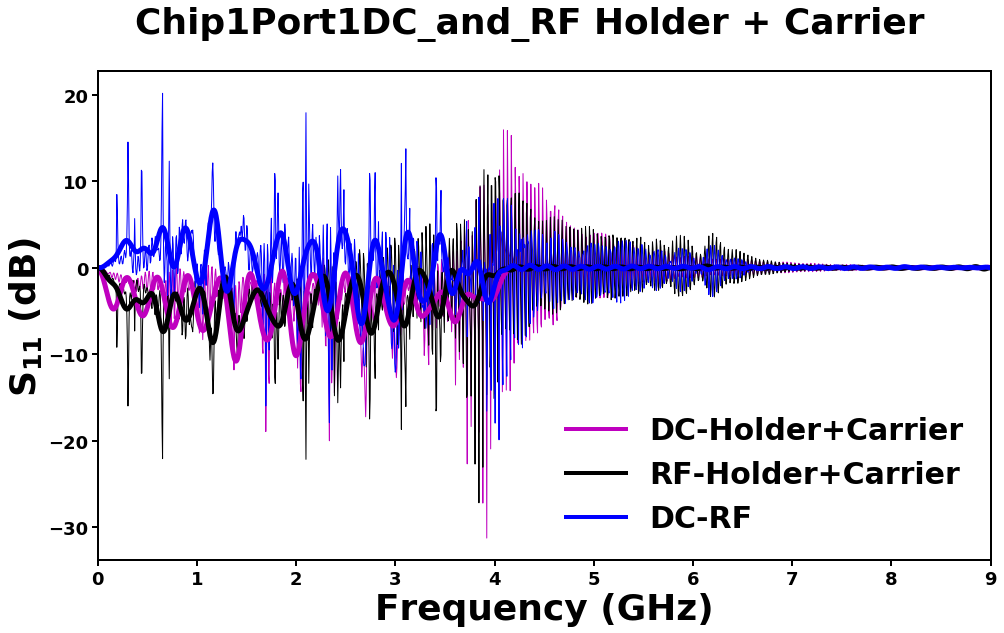

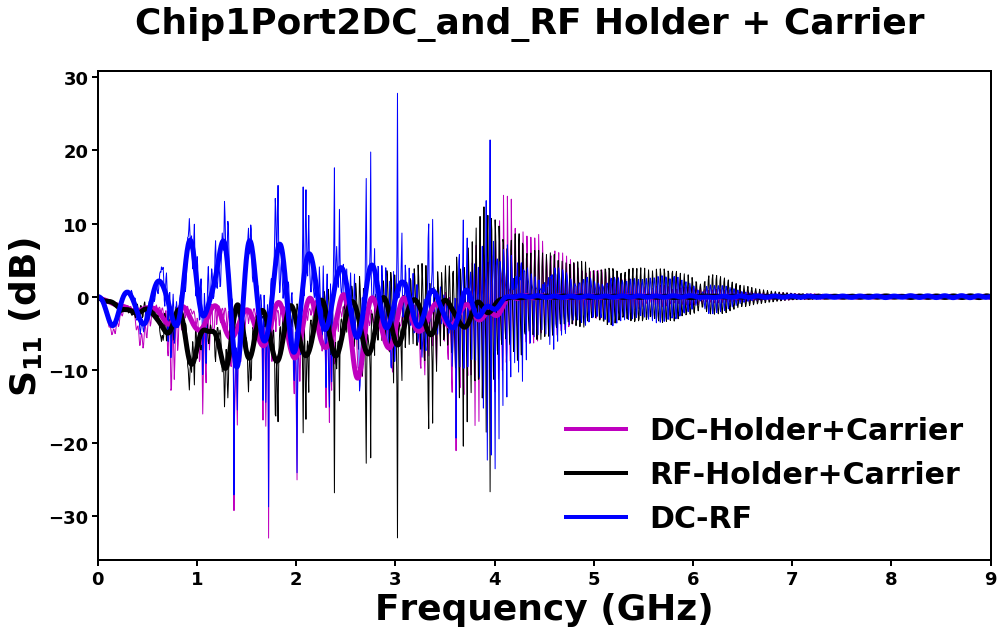

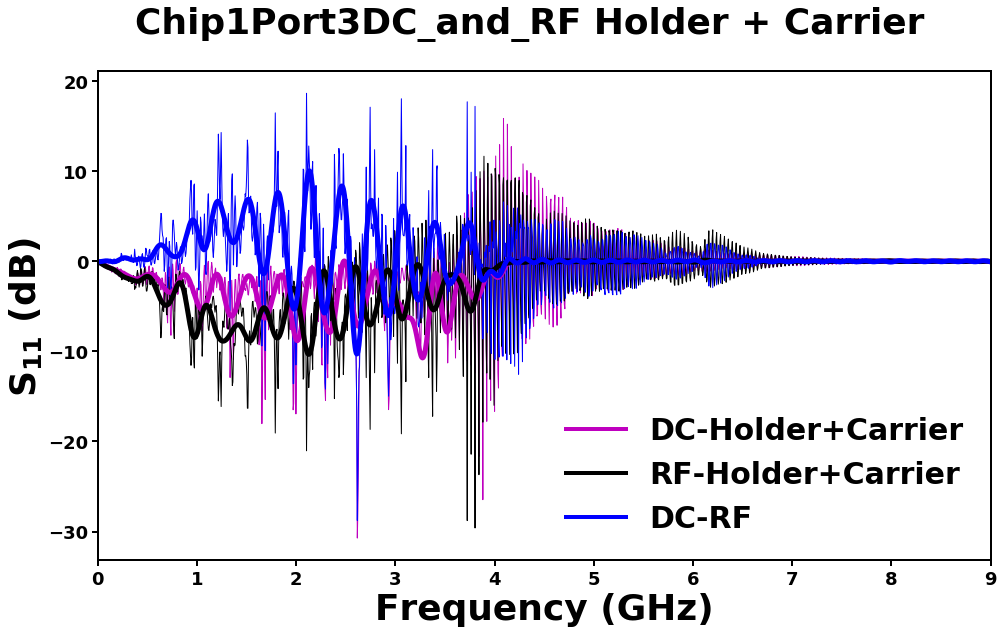

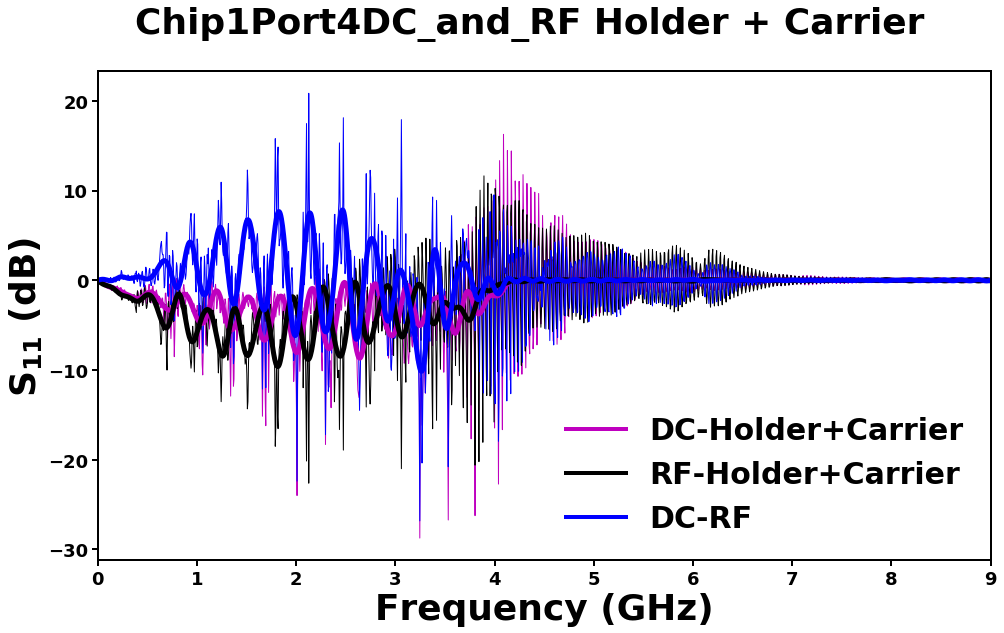

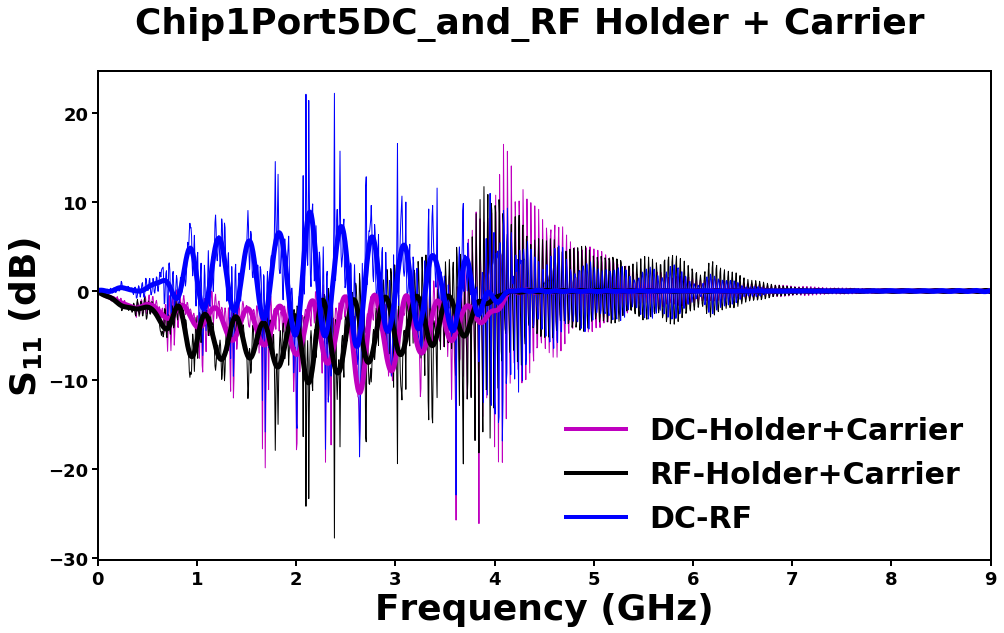

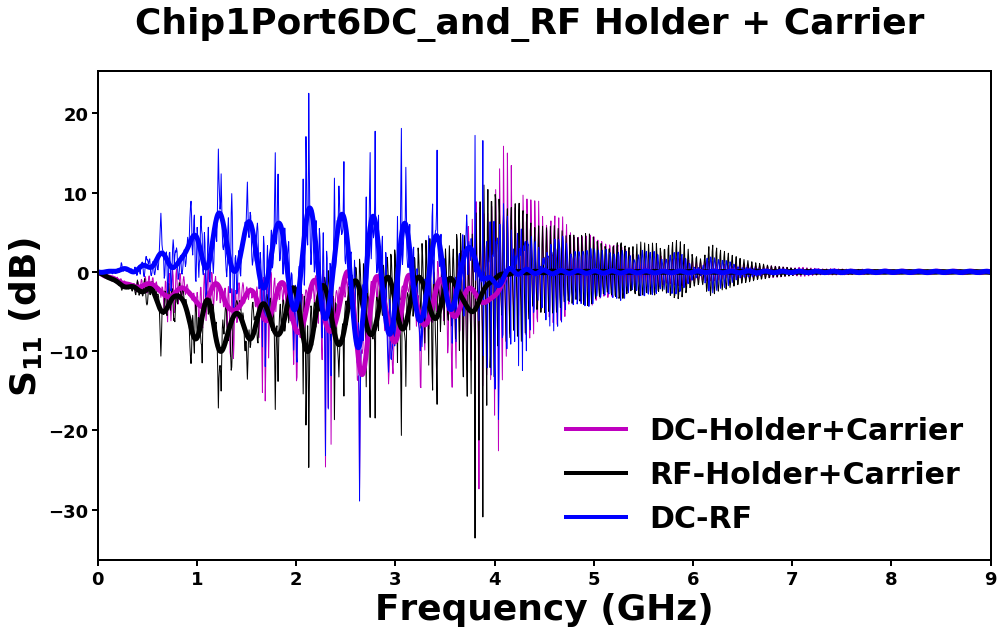

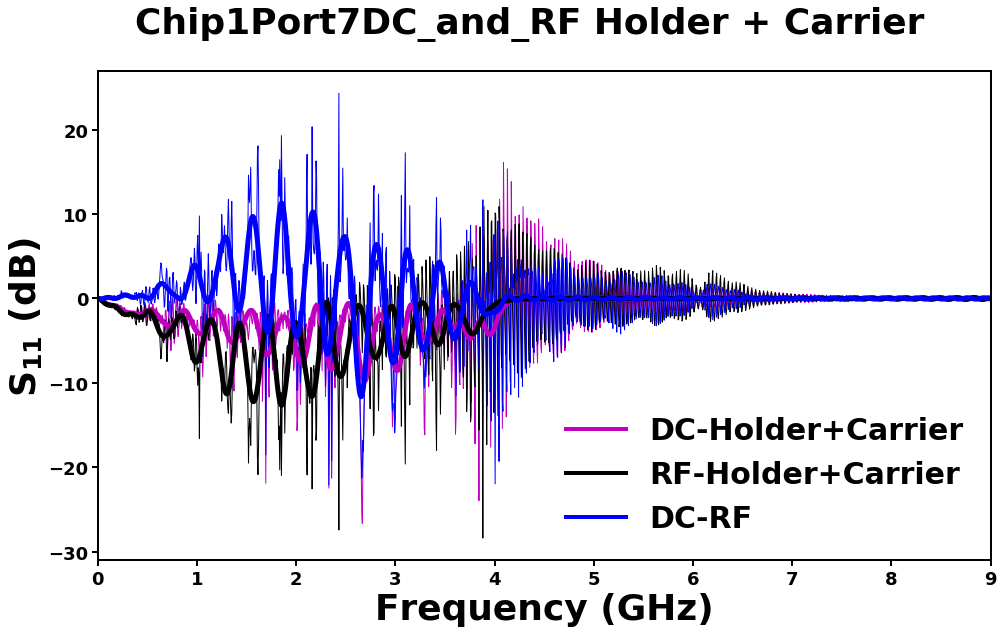

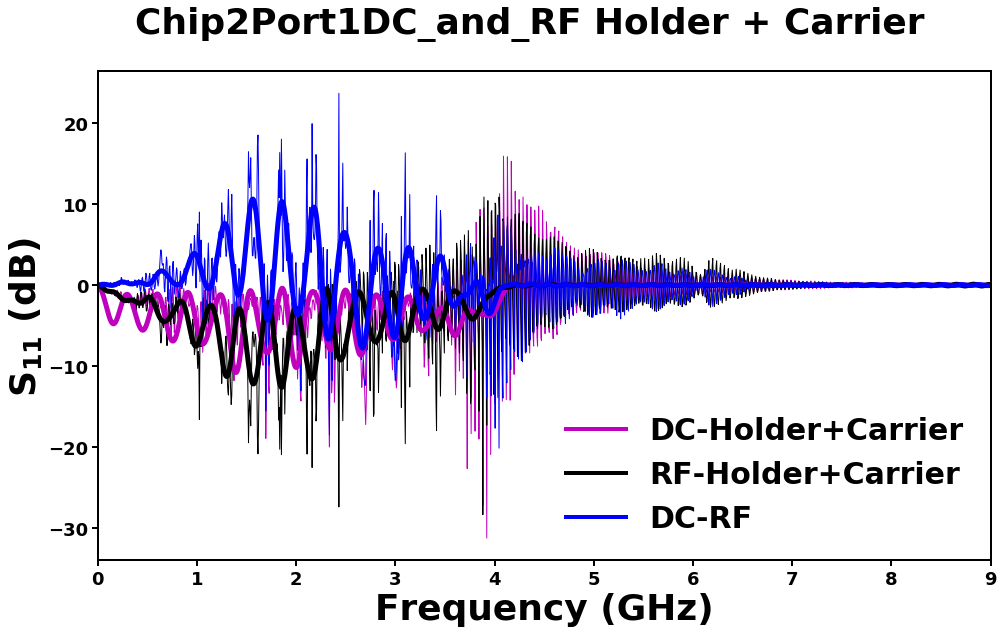

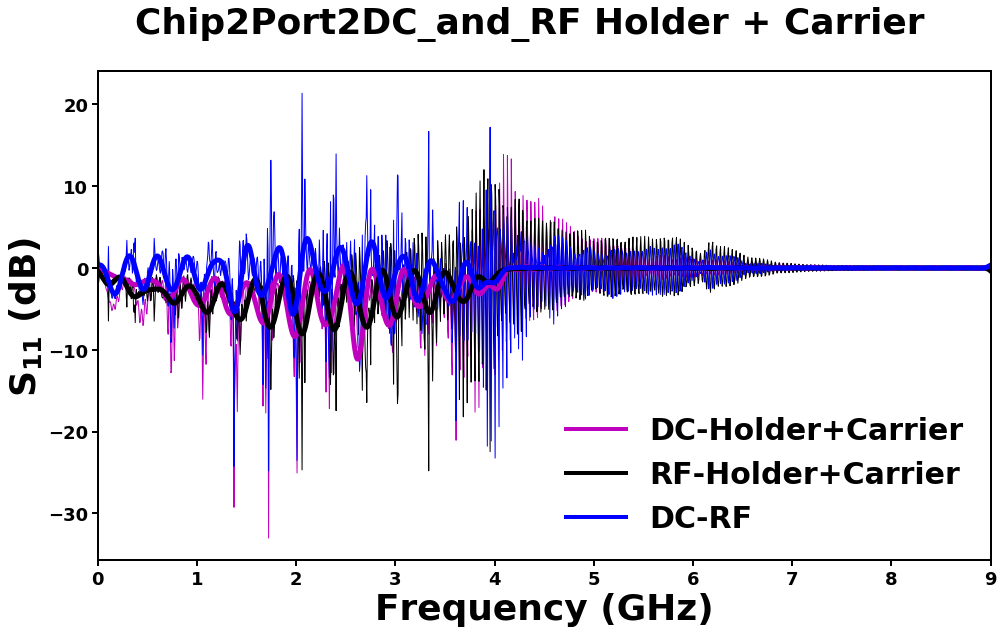

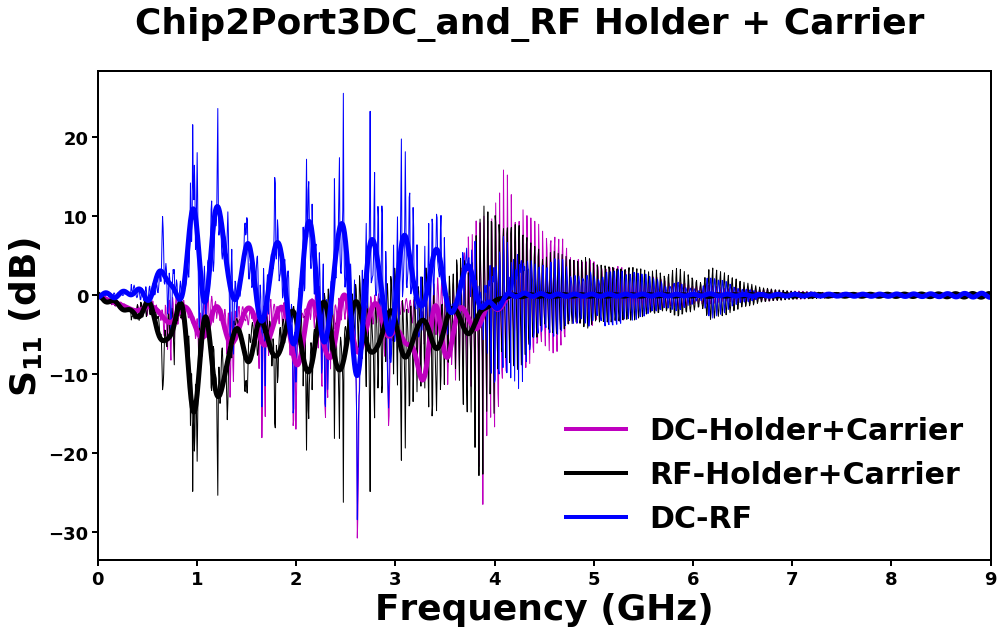

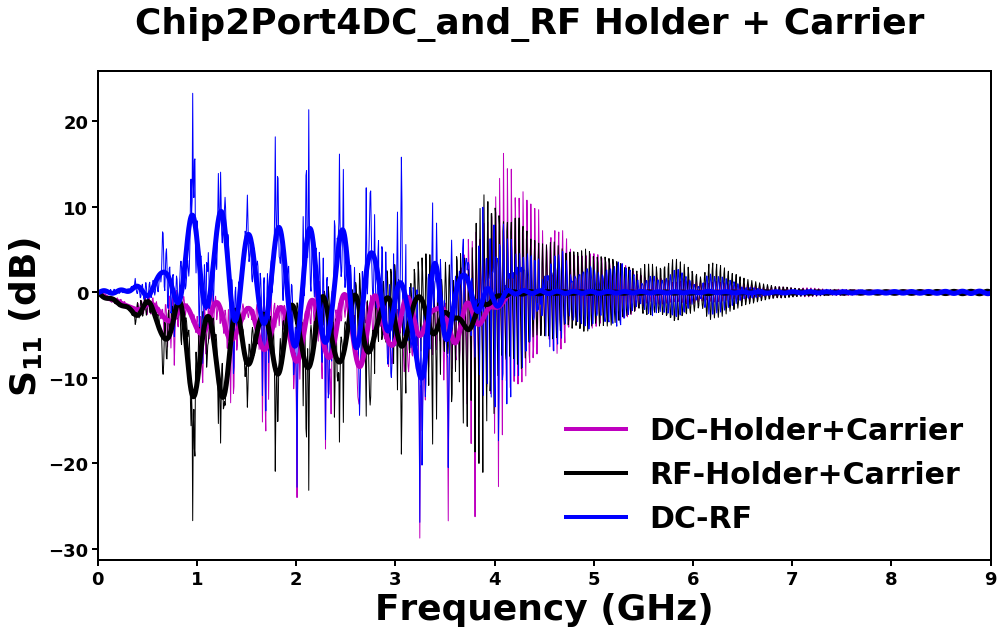

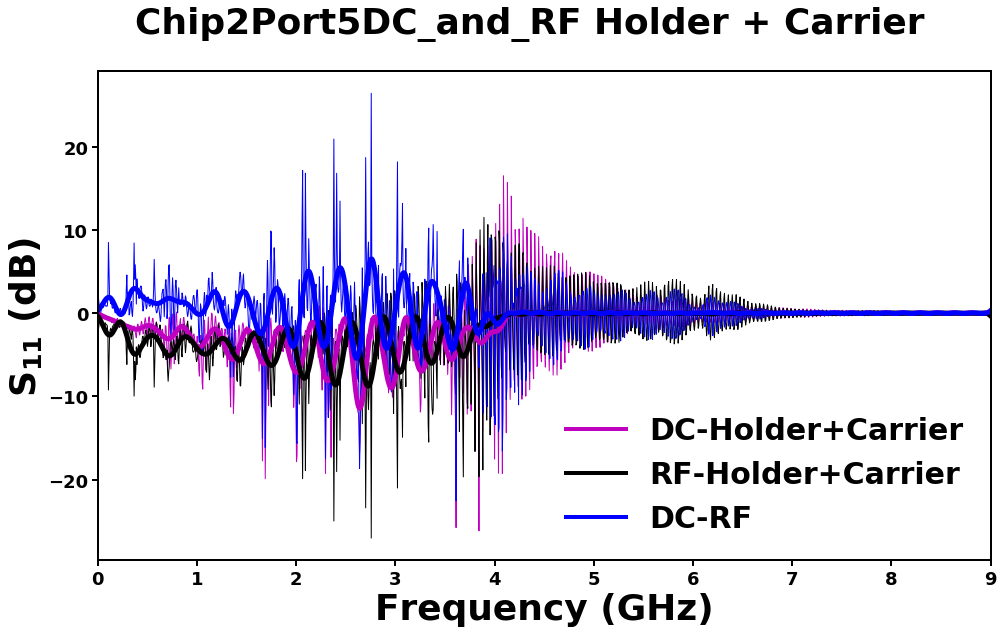

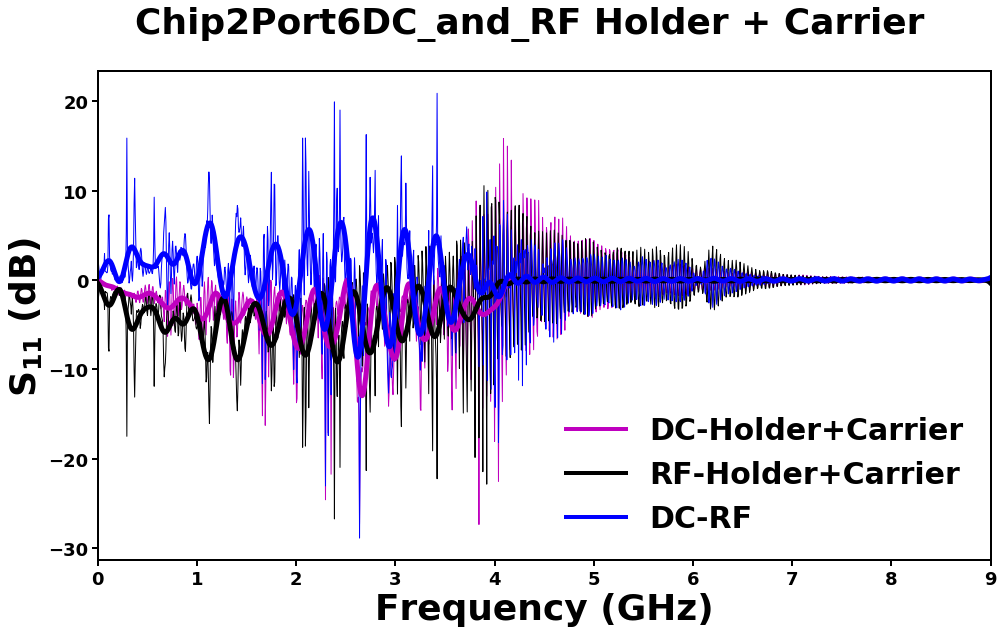

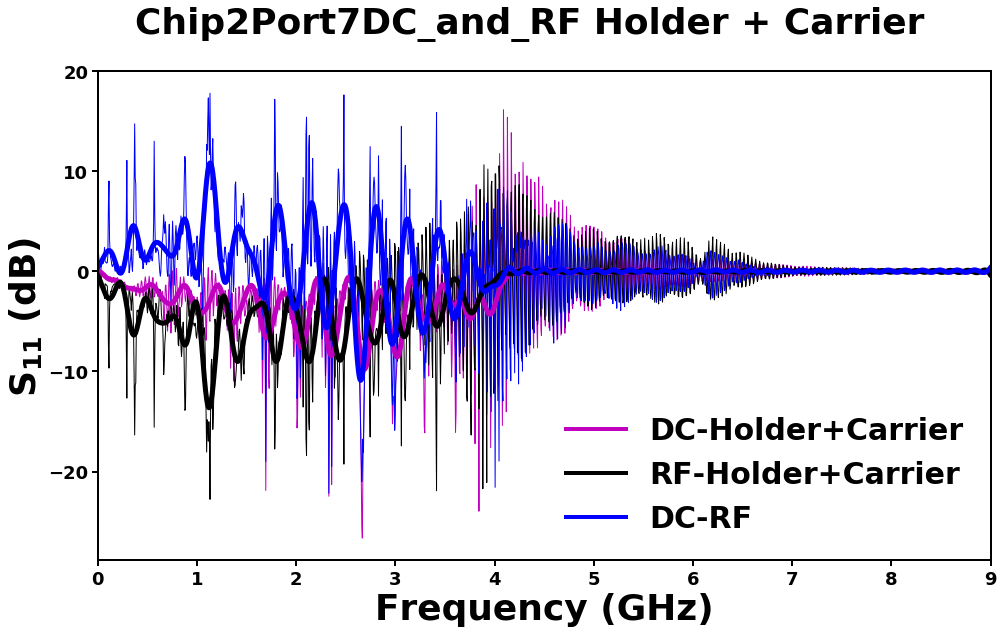

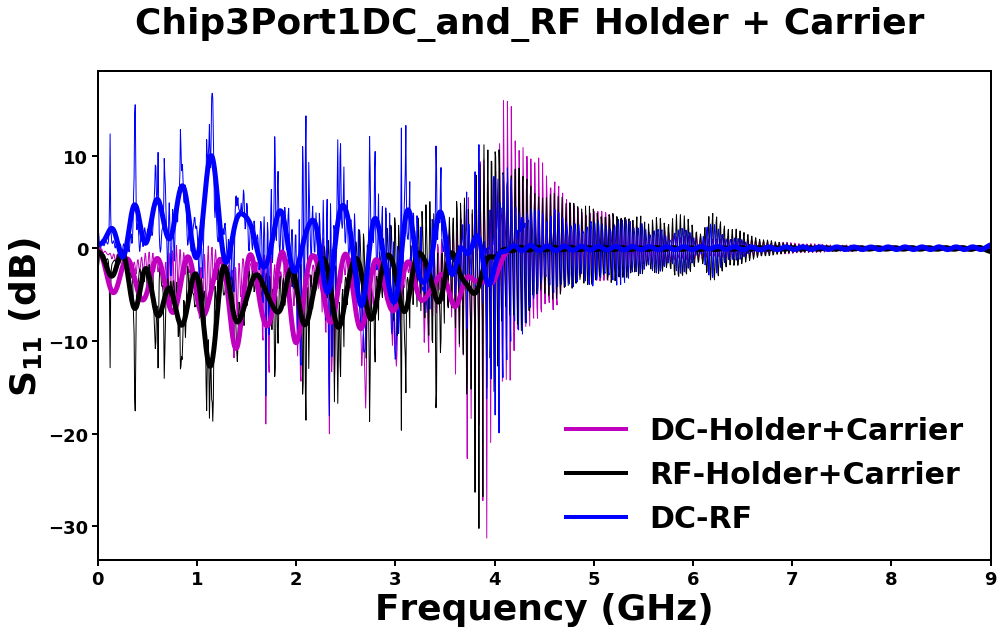

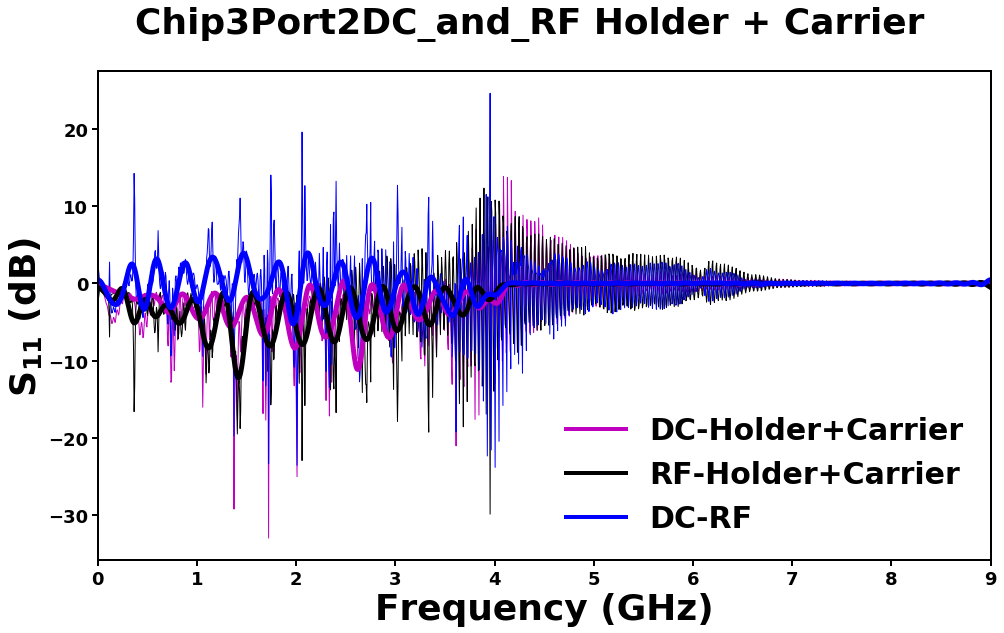

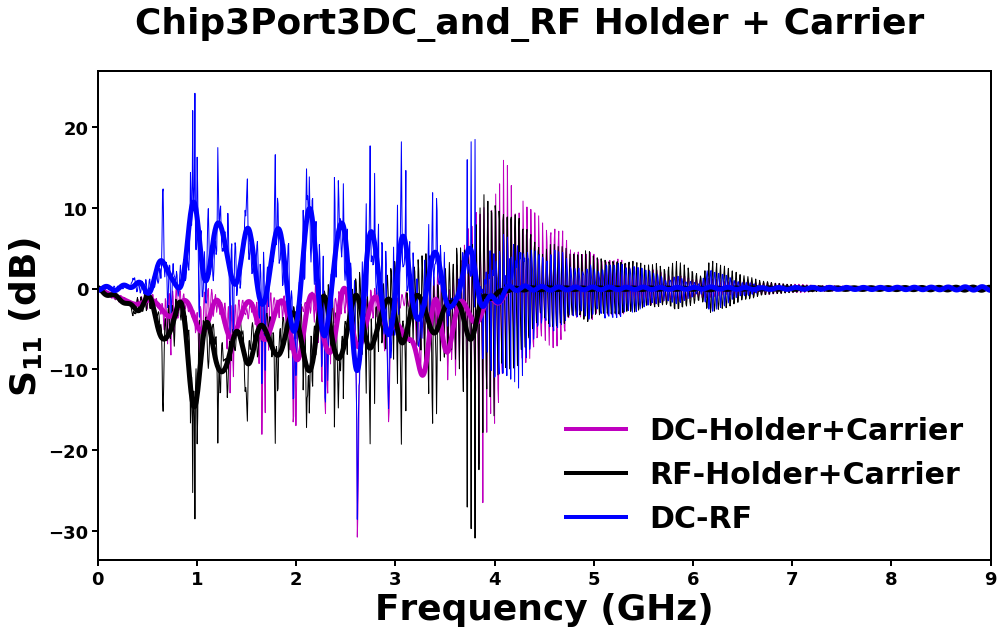

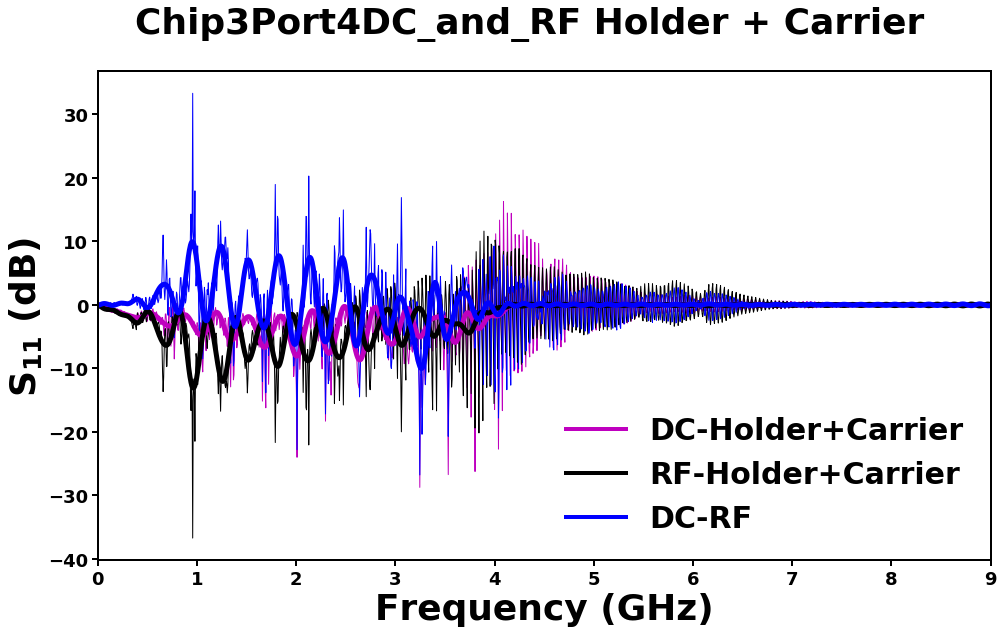

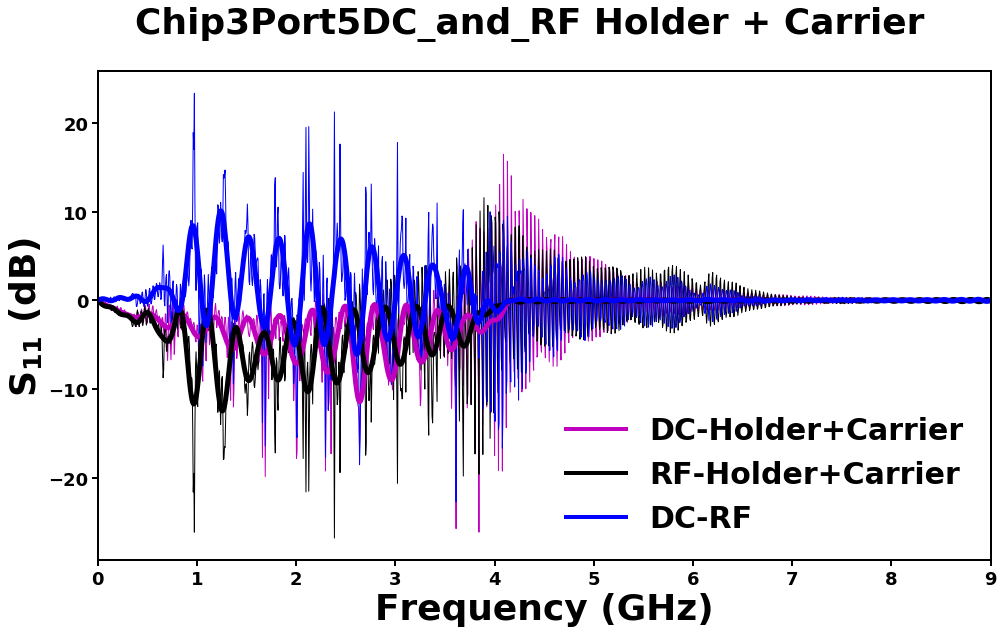

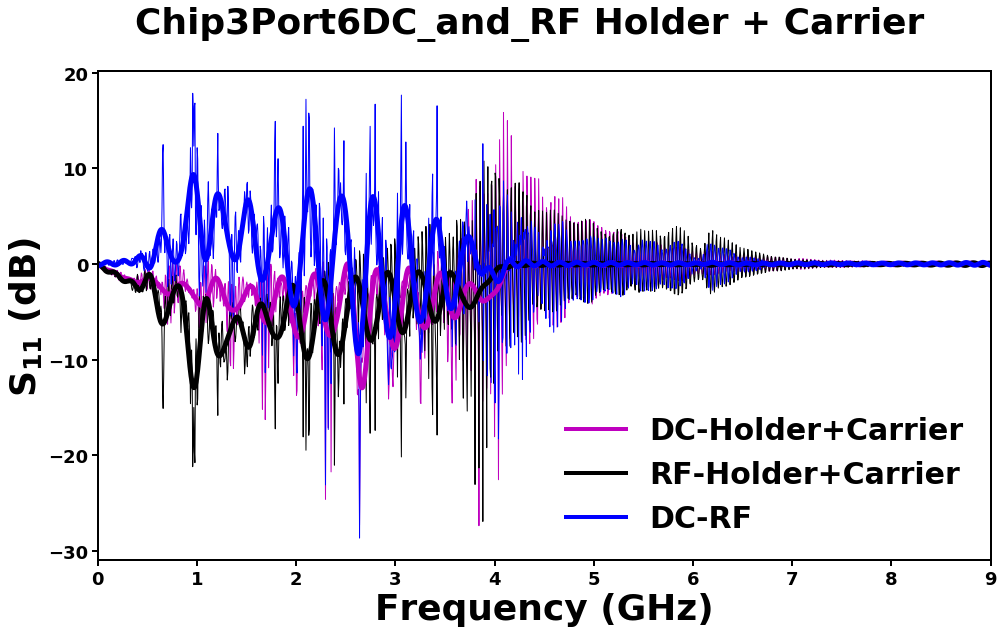

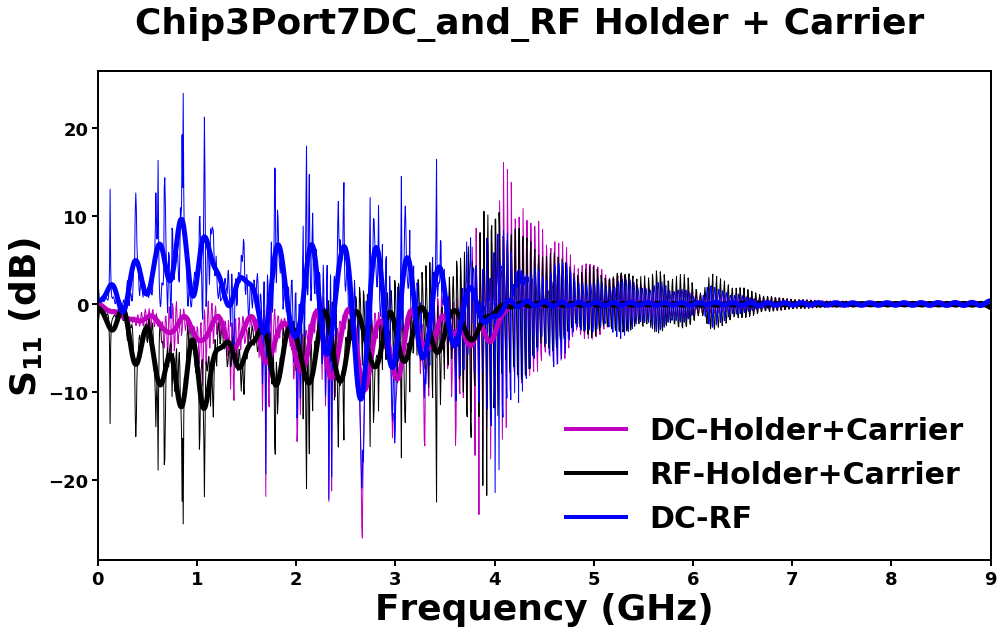

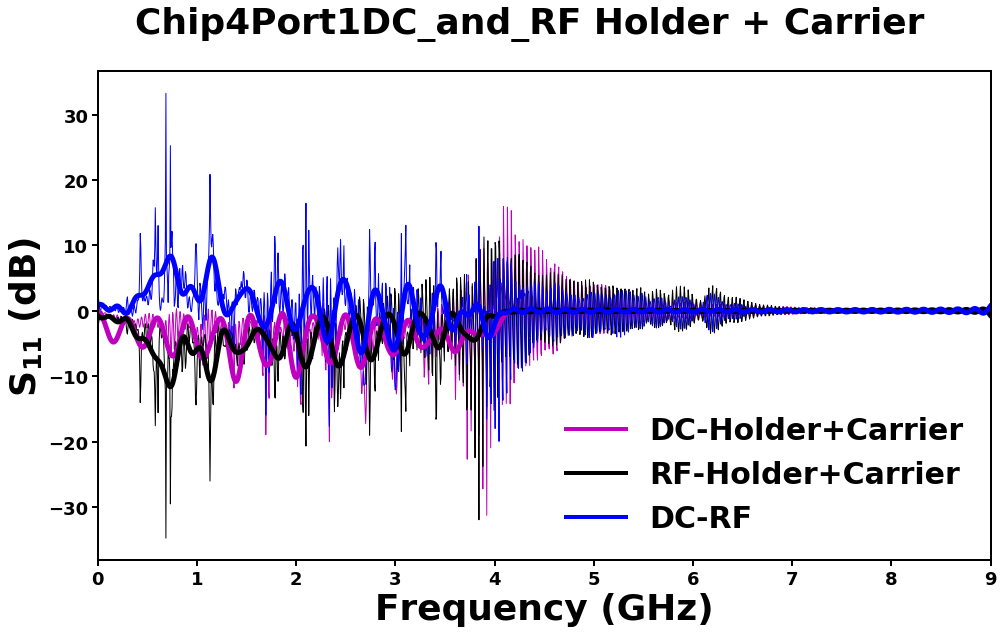

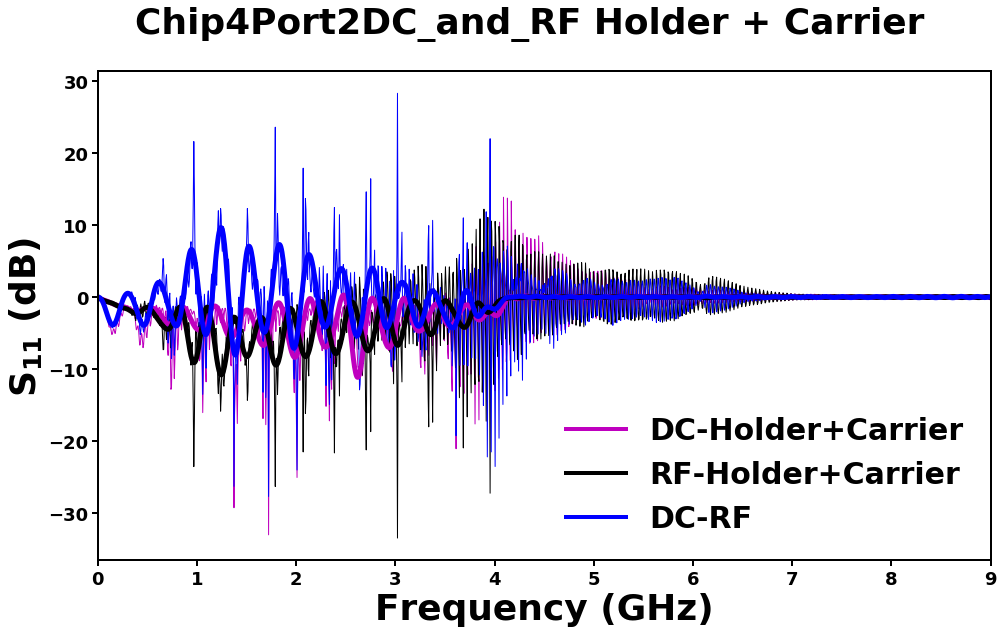

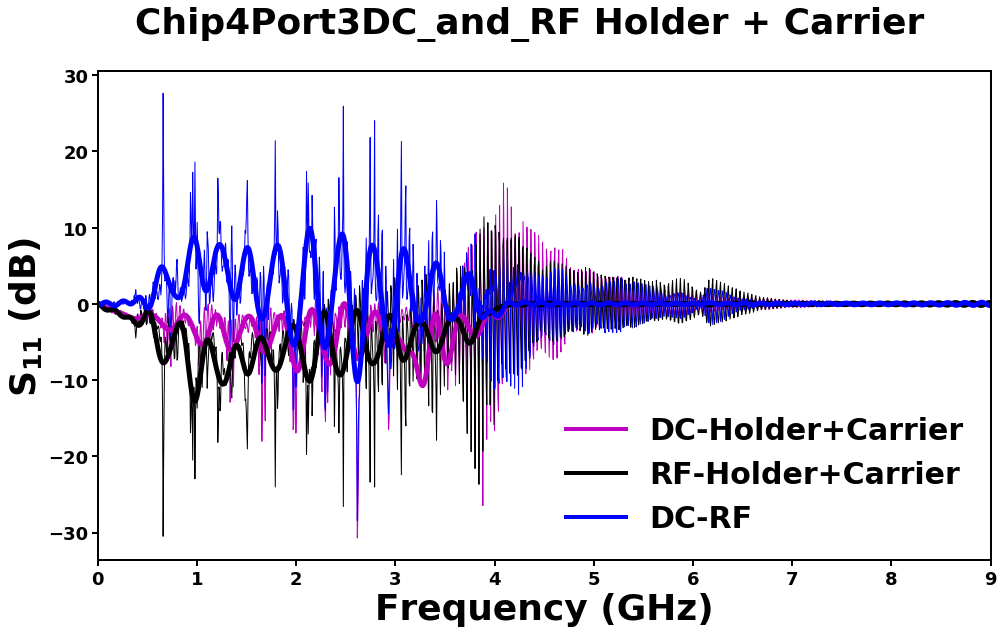

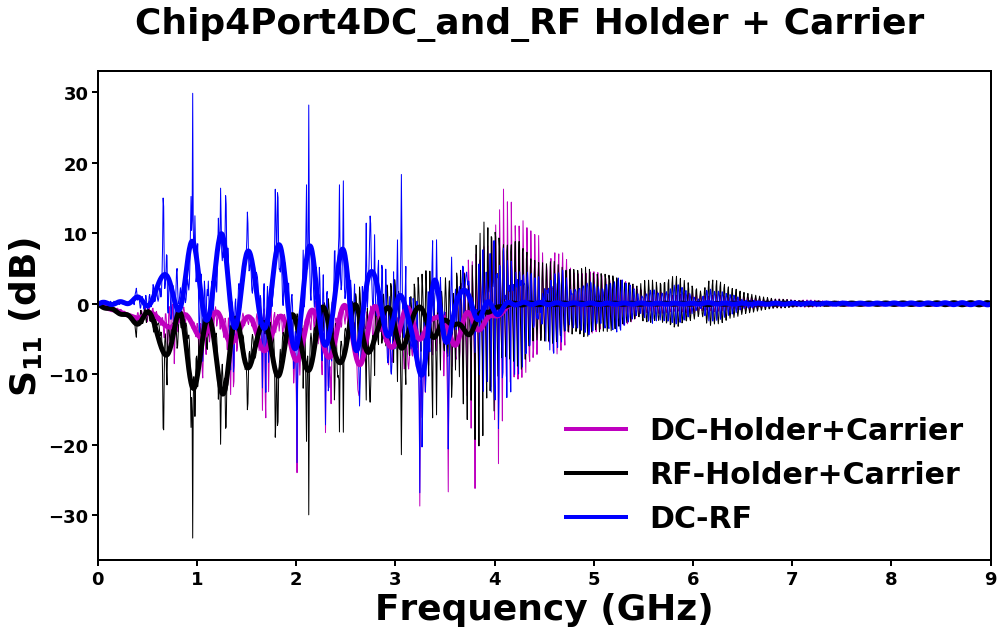

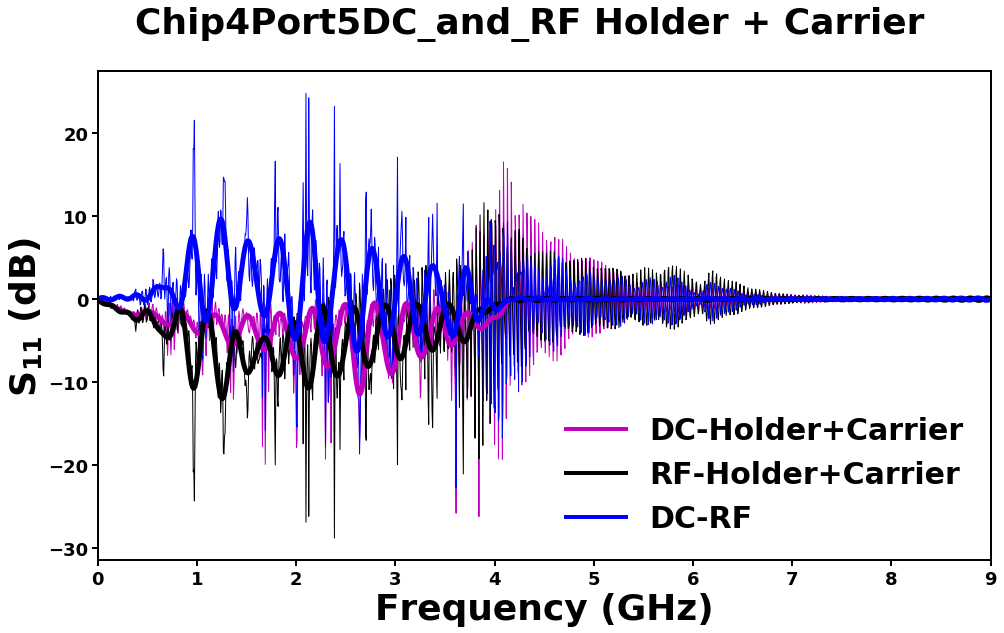

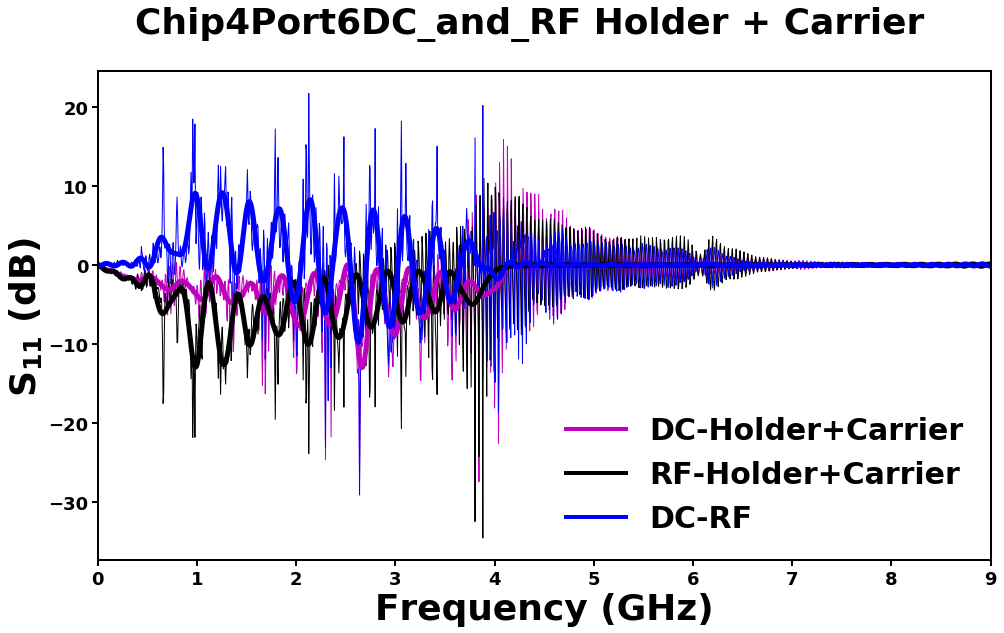

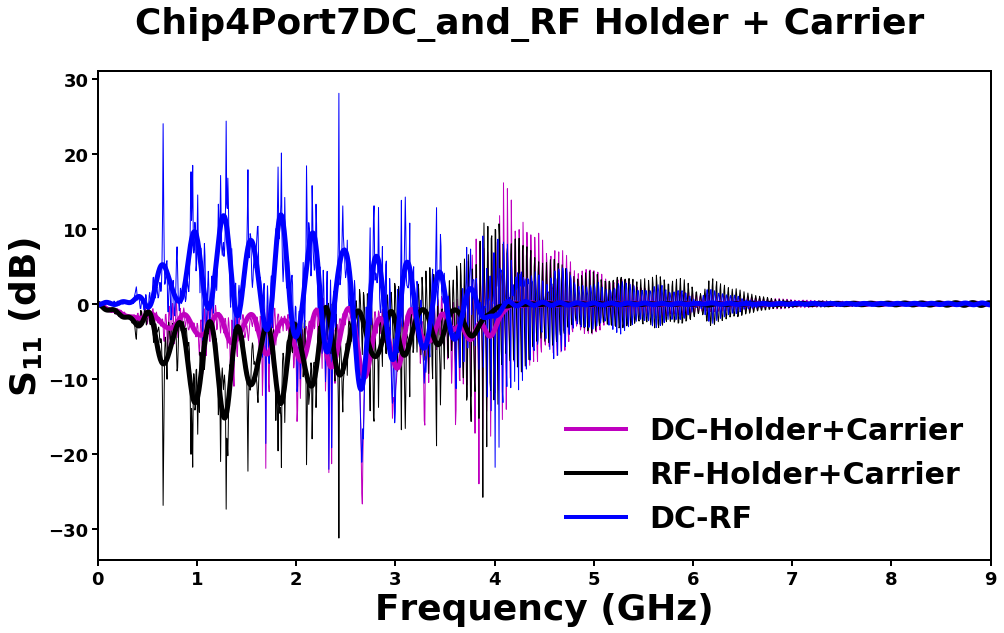

IndexError: index 29 is out of bounds for axis 2 with size 29

In [19]:
## Subtraction of holder background RF data plotting
''' Opens all RF samples and subtracts cable results. Also plots filtered data'''
remove_holder_list= np.array([1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7])-1
plot_file1=np.arange(data_array1.shape[2])+1
#data_array_order=[2,4,6,8,10,12,14] #Used for plotting A experiments
#data_array_order=[3,5,7,9,11,13,15] #Used for plotting B experiments
a=0
for n in plot_file1:
  
    #X=data_A_2[:,0,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    #Y=data_A_2[:,1,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    x_cable1=data_array1[:,0,0]/1e9
    y_cable1=data_array1[:,1,0]
    y_cable1_filt=lowpass_filter(y_cable1,9,3)
    
    x_orig1=data_array1[:,0,n]/1e9
    y_orig1=data_array1[:,1,n]
    #x_filt=data_array[:,0,n] #Used for plotting B experiments as data_B_R, R=1,2
    y_orig1_filt=lowpass_filter(y_orig1,9,3) #Used for plotting B experiments as data_B_R, R=1,2
    
    Y_holder1=y_orig1-y_cable1
    Y_holder1_filt= y_orig1_filt-y_cable1_filt
    
    Y_DC_holder1=data_dc[::2,1,remove_holder_list[a-1]]
    Y_DC_holder1_filt=data_dc_filt[::2,1,remove_holder_list[a]]
    
    Y_carrier1=Y_DC_holder1-Y_holder1
    Y_carrier1_filt=lowpass_filter(Y_DC_holder1-Y_holder1,9,3)
    
    
    
    name_fix=plot_file1[n]+1
    plot_file_name1=str(n+1)
    Data_Name1 = os.path.basename(file_list1[n]).split('.')[0] + 'DC_and_RF Holder + Carrier' #Change name whether R=1,2 and With to Without if A or B

    plt.rc('font', weight='bold')
    plt.rcParams['axes.linewidth']=2
    plt.rcParams['figure.figsize'] = (16,9)

    fig1 = plt.figure()
    fig1.suptitle(Data_Name1, fontsize=36, fontweight='bold')

    ax1 = fig1.add_subplot(111)

    ax1.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
    ax1.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')
    ax1.set_xlim(0,9)

    ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
#     ax1.xaxis.get_offset_text().set_visible(False)

    #fig=plt.plot(X,Y,'k-',label='Chip')
    fig1=plt.plot(x_orig1,Y_DC_holder1,'m-',linewidth=1, label='DC-Holder+Carrier') 
    fig1=plt.plot(x_orig1,Y_holder1,'k-',linewidth=1, label='RF-Holder+Carrier')
    fig1=plt.plot(x_orig1,Y_carrier1,'b-',linewidth=1, label='DC-RF')
     
    
    #fig=plt.plot(x_orig,y_orig,'r-',linewidth=1, label='As Measured')
    
    
    #fig=plt.plot(x_orig[:-1],y_orig_filt,'r-',linewidth=5)
    
    fig=plt.plot(x_orig1[:-1],Y_DC_holder1_filt,'m-',linewidth=5)
    fig=plt.plot(x_orig1[:-1],Y_holder1_filt,'k-',linewidth=5)
    fig=plt.plot(x_orig1[:-1],Y_carrier1_filt,'b-',linewidth=5)
    

    leg1=plt.legend(fontsize=30, loc=4, frameon=False)

    for legobj in leg1.legendHandles:
        legobj.set_linewidth(4.0)

    a+=1
    plt.show()
#     save_loc='C:\\Users\\kbs1\\Documents\\TEMCarrierApr2018\\Both'+ '/' +Data_Name+'.png' #root.directory+'/'+'Updated61918'+ '/' +Data_Name+'.png'
#     plt.savefig(save_loc)

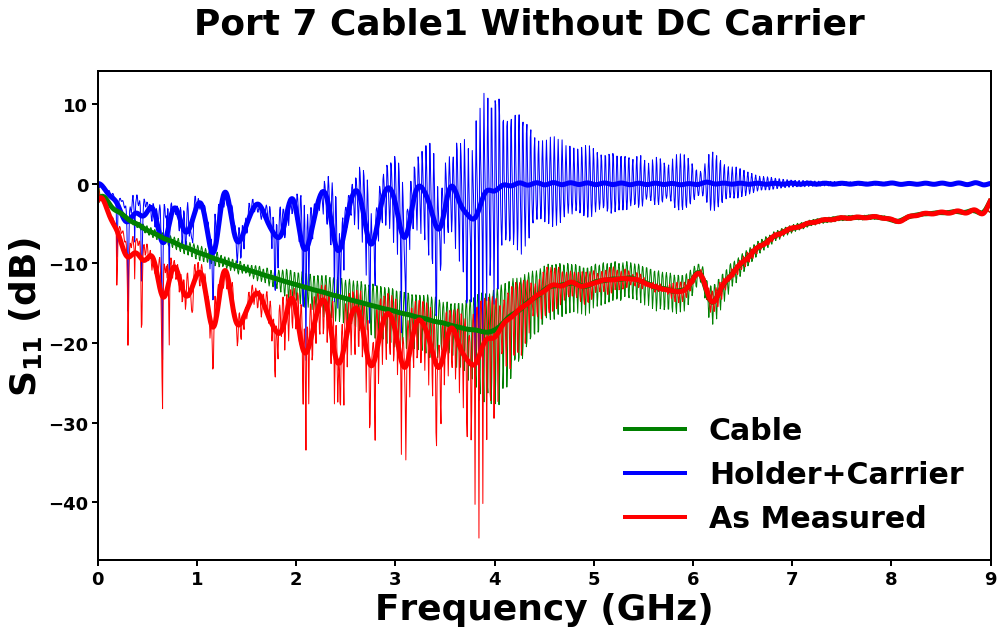

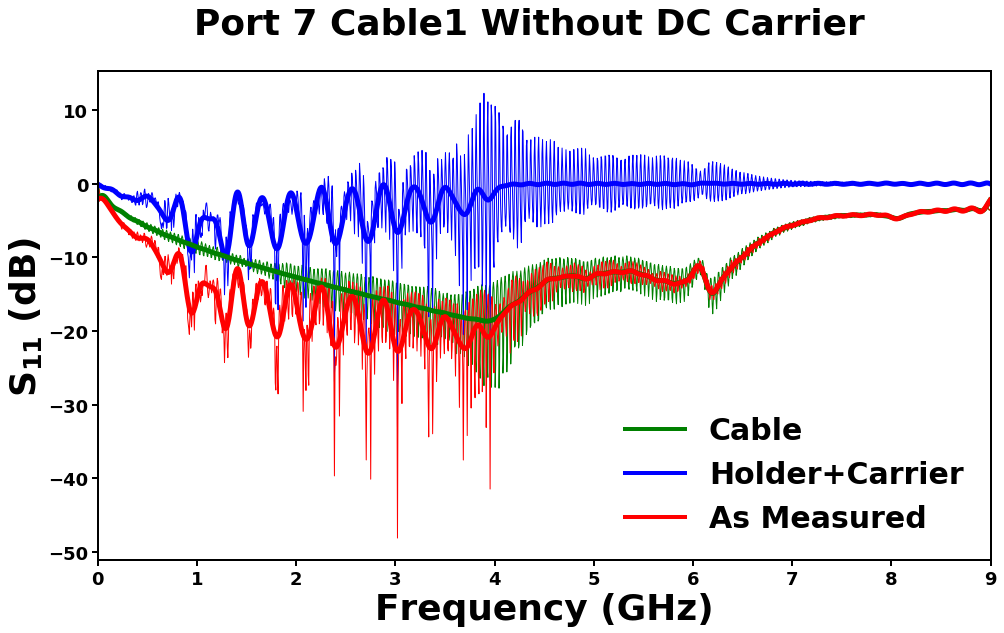

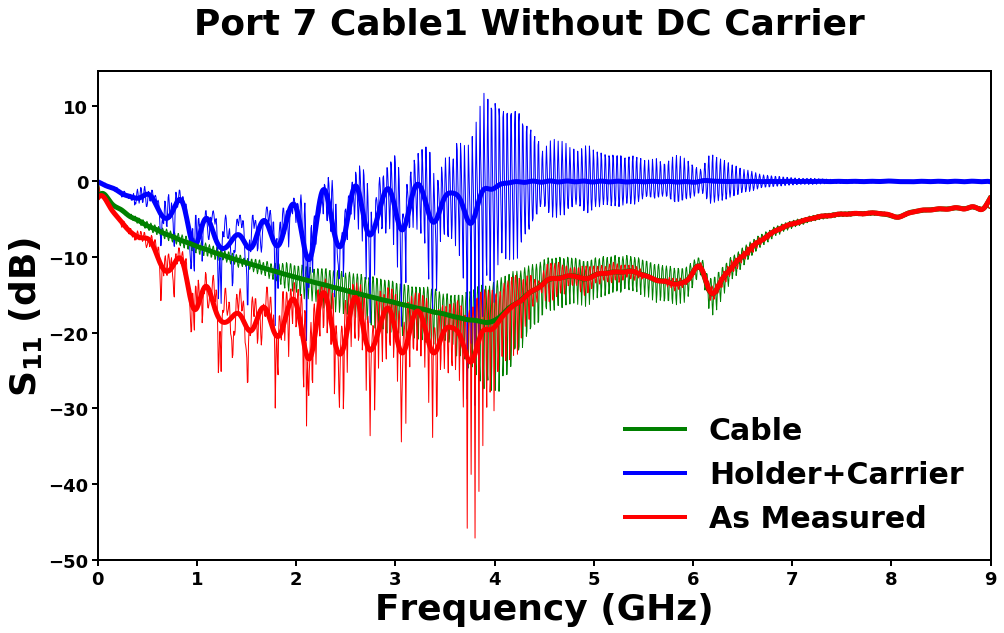

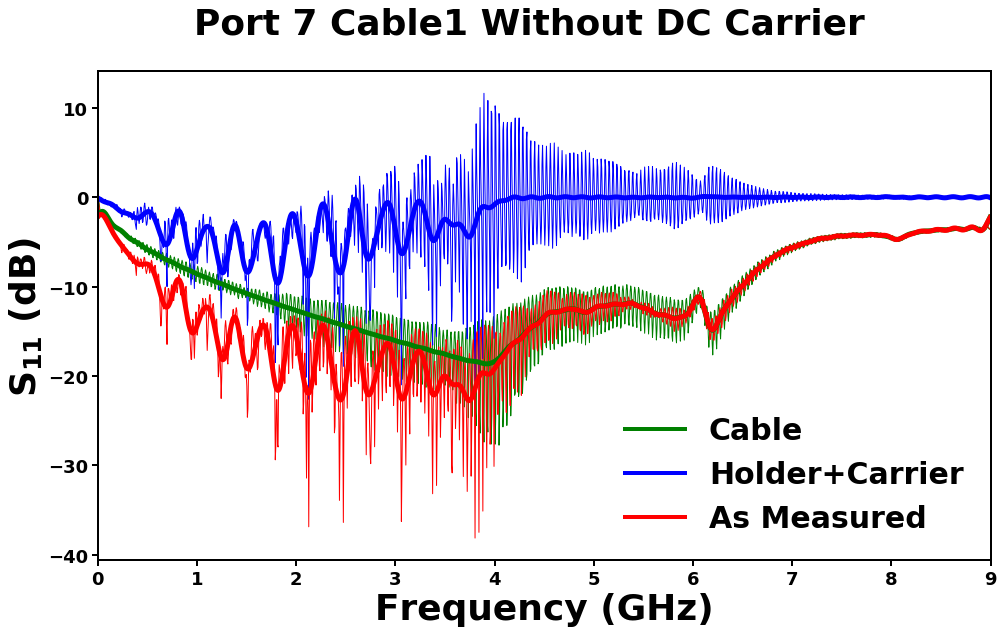

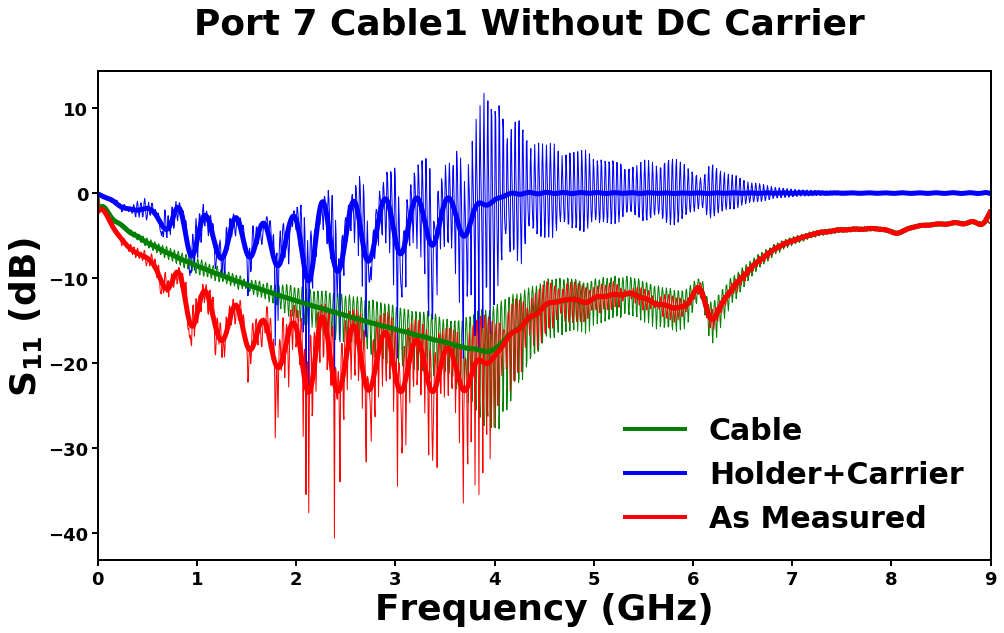

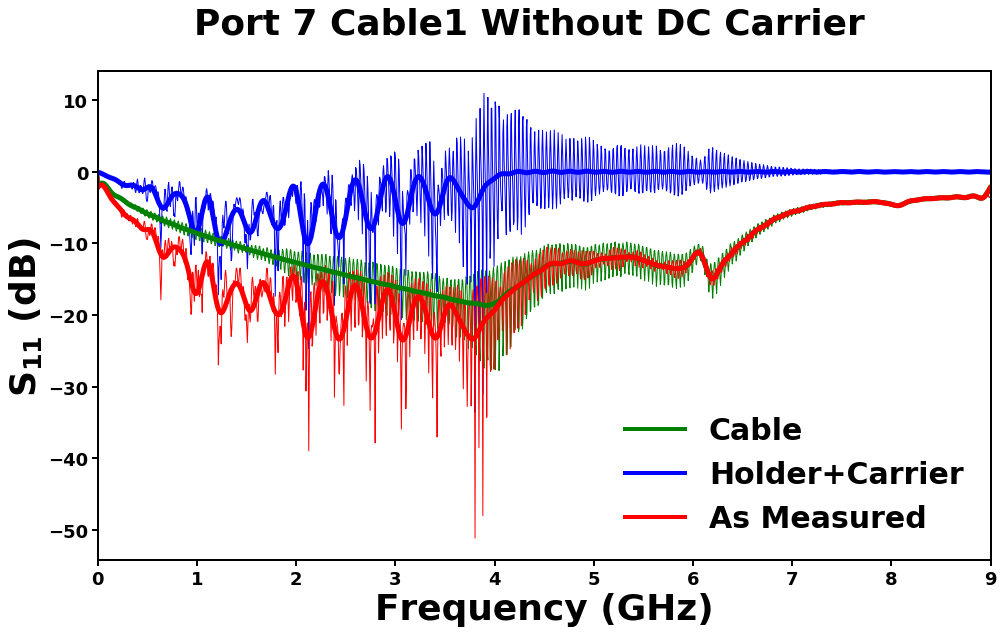

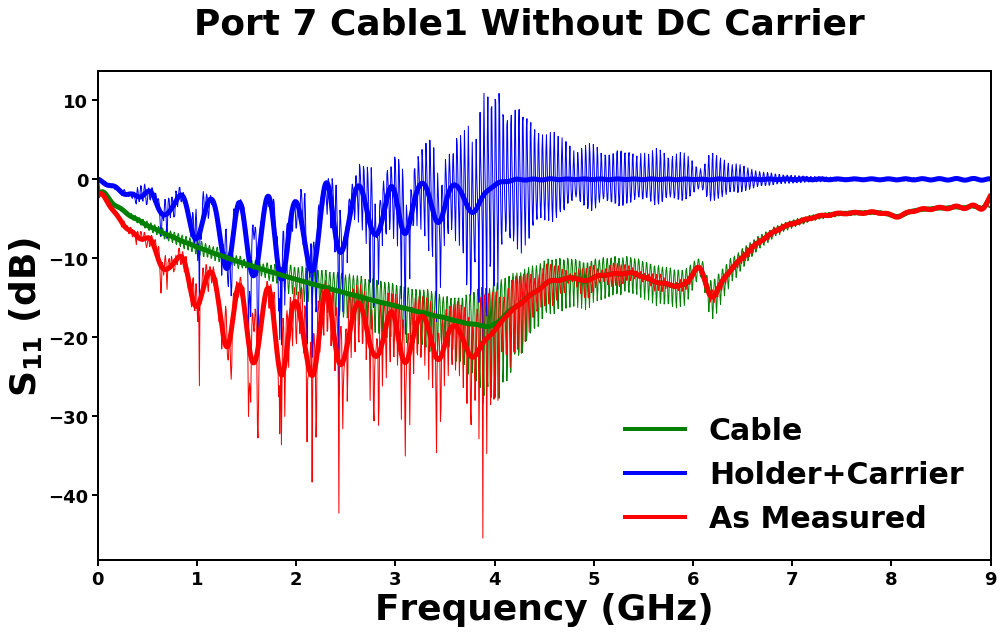

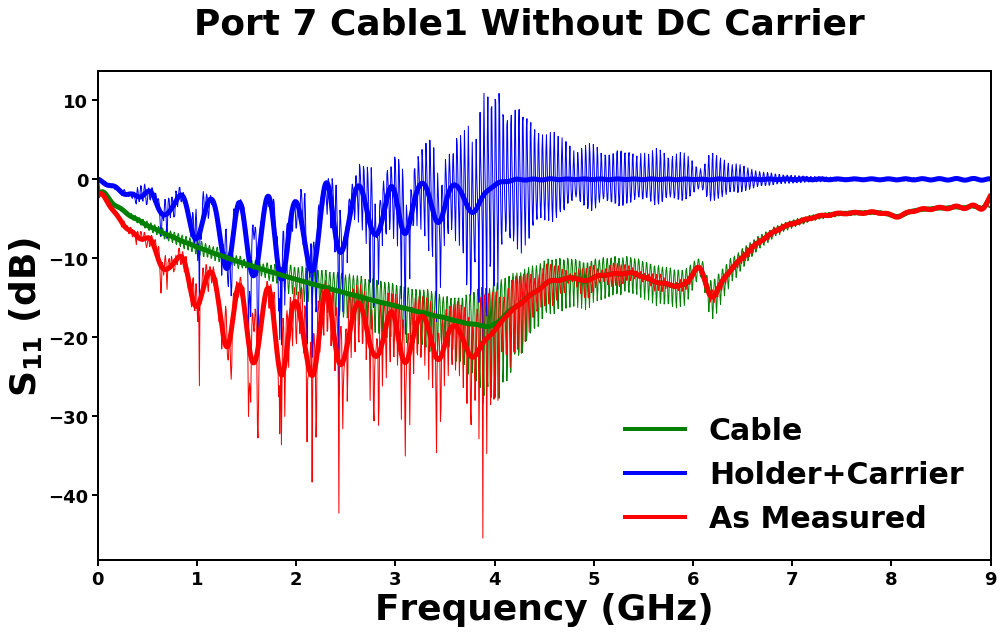

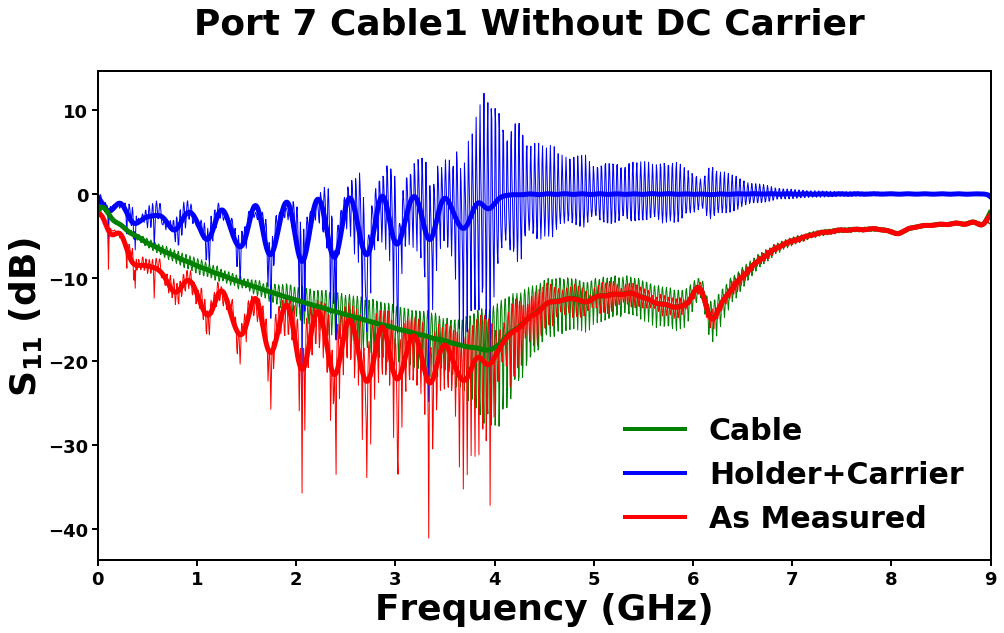

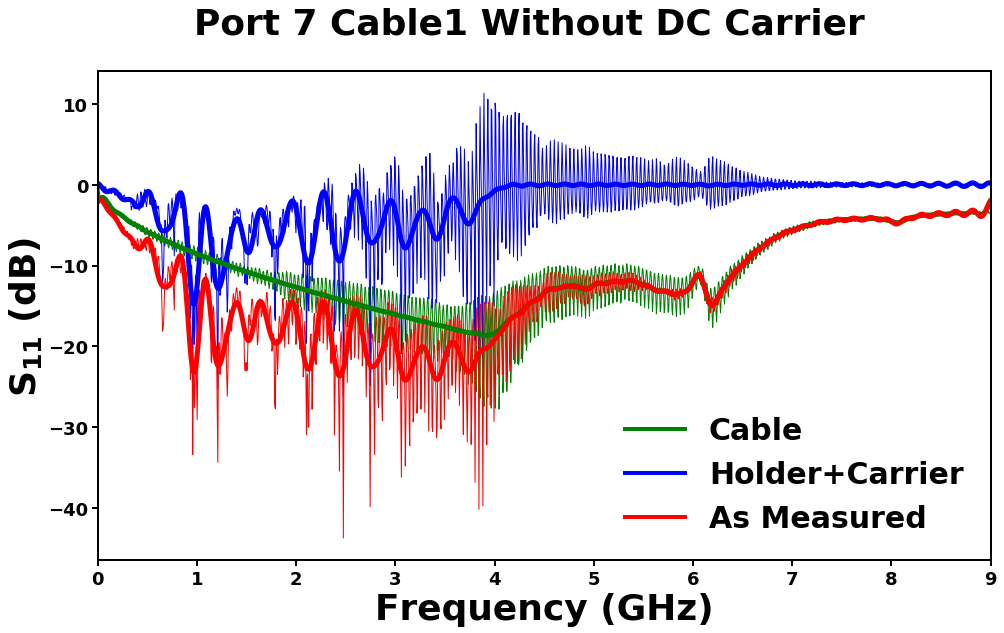

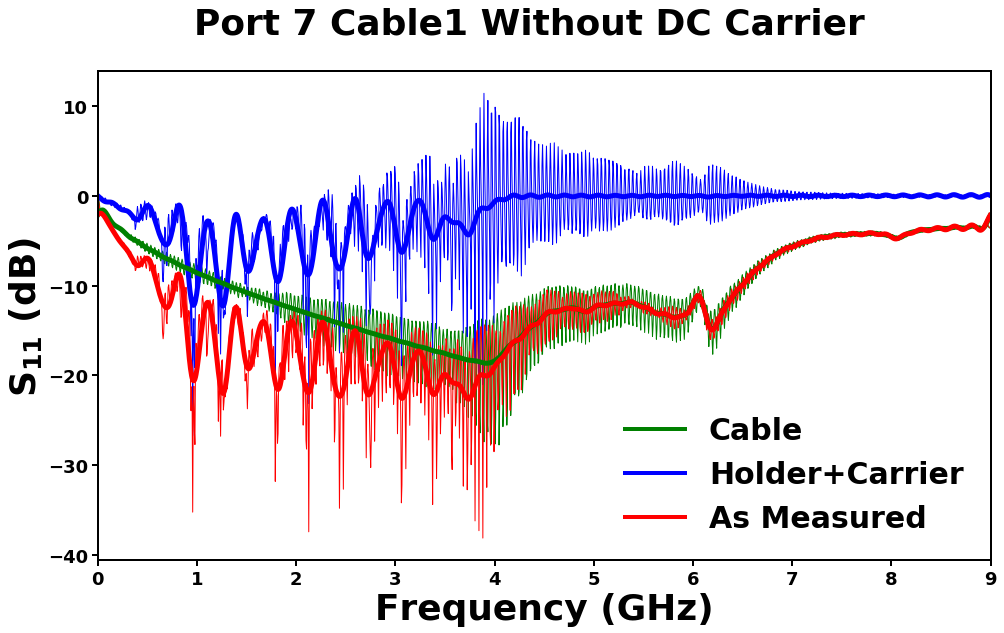

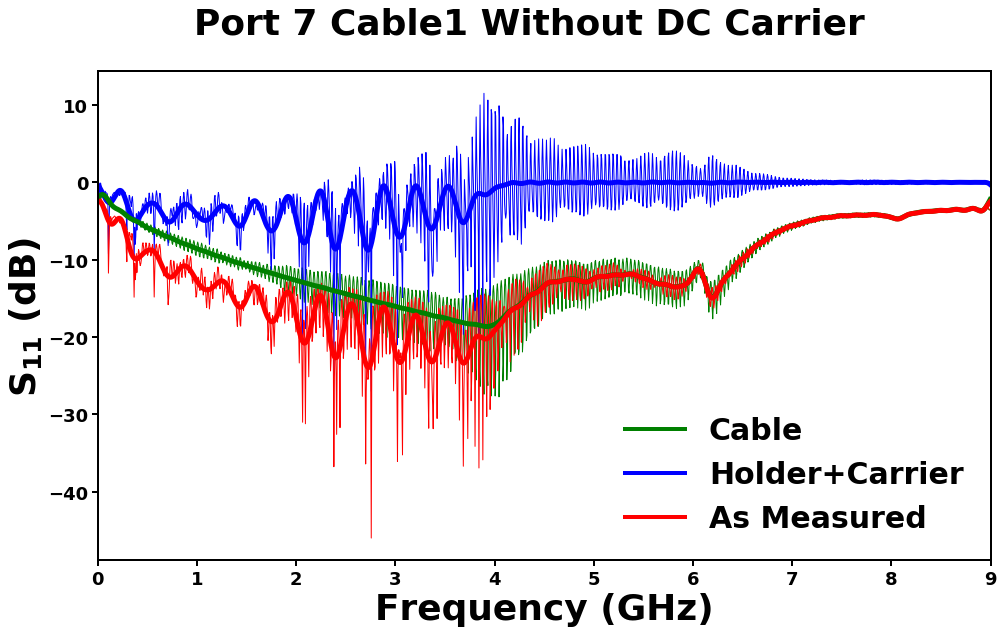

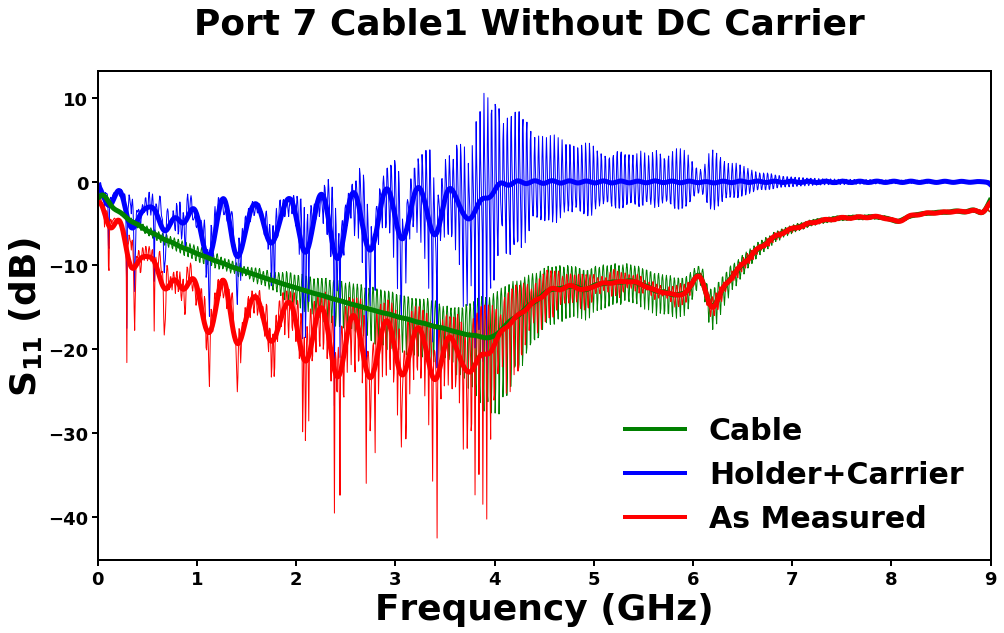

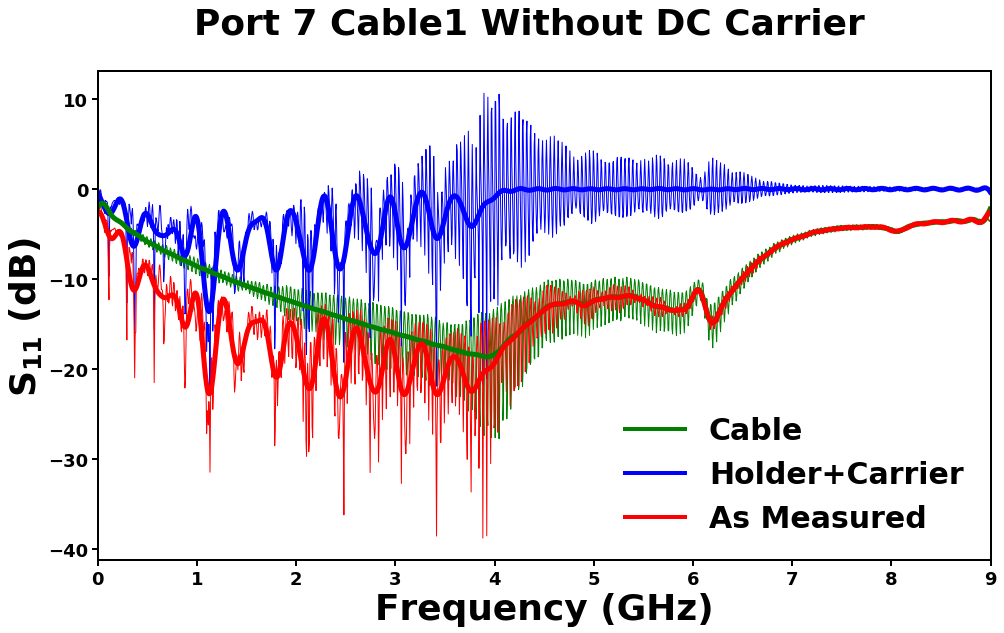

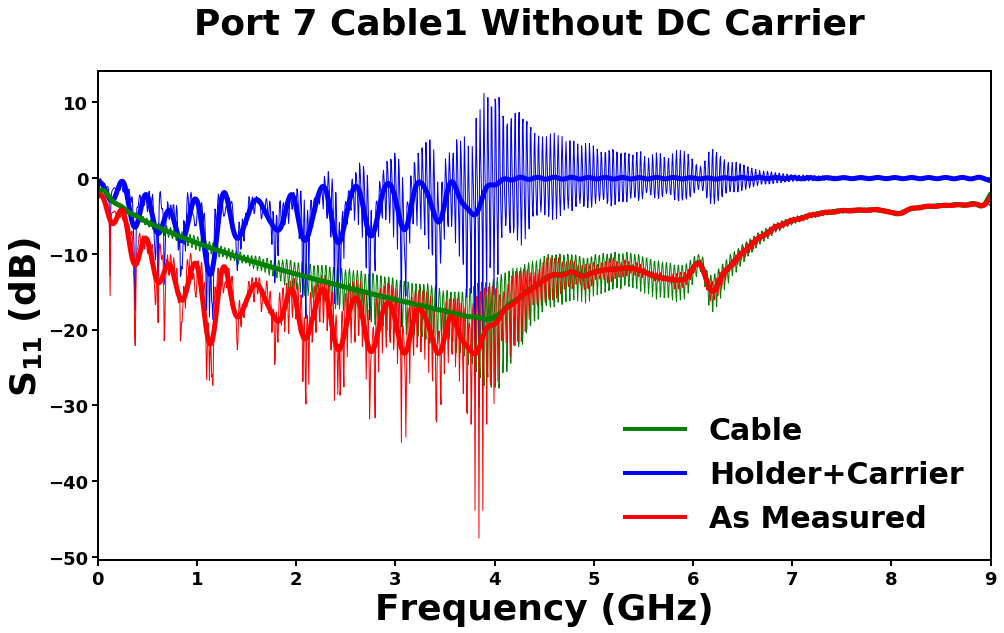

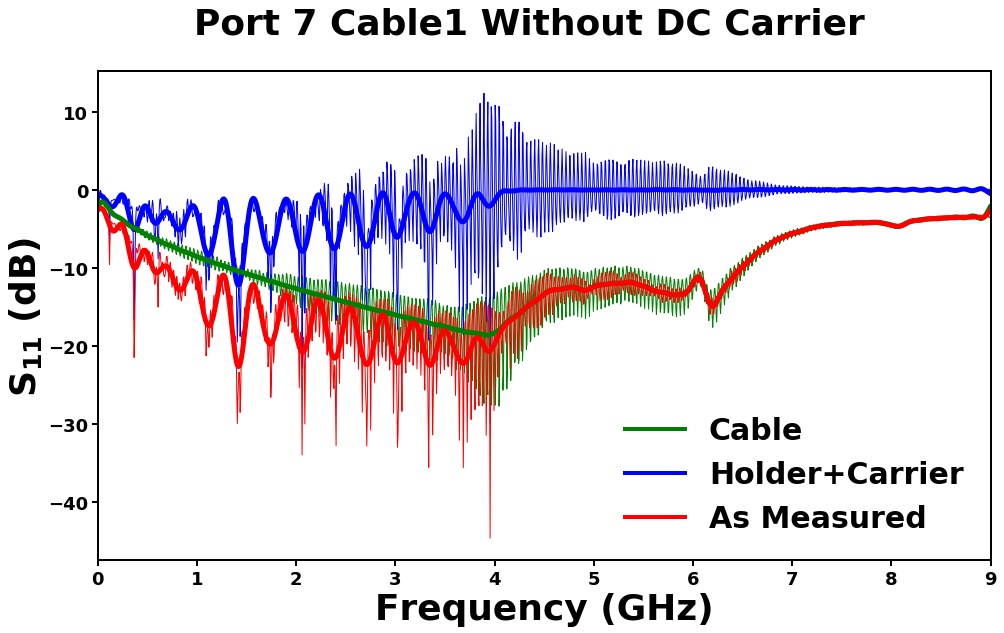

IndexError: list index out of range

In [20]:
## RF data plotting
''' Opens all RF samples and subtracts cable results. Also plots filtered data'''
plot_file=np.arange(data_array1.shape[2]-1)+1
#data_array_order=[2,4,6,8,10,12,14] #Used for plotting A experiments
#data_array_order=[3,5,7,9,11,13,15] #Used for plotting B experiments
a=0
for n in plot_file1:
  
    #X=data_A_2[:,0,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    #Y=data_A_2[:,1,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    x_cable2=data_array1[:,0,0]/1e9
    y_cable2=data_array1[:,1,0]
    y_cable2_filt=lowpass_filter(y_cable2,9,3)
    
    x_orig2=data_array1[:,0,n]/1e9
    y_orig2=data_array1[:,1,n]
    #x_filt=data_array[:,0,n] #Used for plotting B experiments as data_B_R, R=1,2
    y_orig2_filt=lowpass_filter(y_orig2,9,3) #Used for plotting B experiments as data_B_R, R=1,2
    
    Y_holder2=y_orig2-y_cable2
    Y_holder2_filt= y_orig2_filt-y_cable2_filt
    
    name_fix=plot_file1[n]+1
    plot_file2_name=str(n+1)
    Data_Name2 = os.path.basename(file_list[n]).split('.')[0] + '_RF_Chip' #Change name whether R=1,2 and With to Without if A or B

    plt.rc('font', weight='bold')
    plt.rcParams['axes.linewidth']=2
    plt.rcParams['figure.figsize'] = (16,9)

    fig2 = plt.figure()
    fig2.suptitle(Data_Name, fontsize=36, fontweight='bold')

    ax2 = fig2.add_subplot(111)

    ax2.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
    ax2.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')
    ax2.set_xlim(0,9)
    
    ax2.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
    ax2.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
#     ax2.xaxis.get_offset_text().set_visible(False)

    #fig=plt.plot(X,Y,'k-',label='Chip')
    fig2=plt.plot(x_cable2,y_cable2,'g-',linewidth=1, label='Cable')  
    fig2=plt.plot(x_orig2,Y_holder2,'b-',linewidth=1, label='Holder+Carrier')
    fig2=plt.plot(x_orig2,y_orig2,'r-',linewidth=1, label='As Measured')
    
    fig2=plt.plot(x_orig2[:-1],Y_holder2_filt,'b-',linewidth=5)
    fig2=plt.plot(x_cable2[:-1],y_cable2_filt,'g-',linewidth=5)
    fig2=plt.plot(x_orig2[:-1],y_orig2_filt,'r-',linewidth=5)
    
    

    leg=plt.legend(fontsize=30, loc=4, frameon=False)

    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)

    plt.show()
    #save_loc=root.directory+'/'+'Updated61918'+ '/' +Data_Name+'.png'
    #plt.savefig(save_loc)